In [60]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *
from scipy.optimize import curve_fit

# Analysis functions

In [61]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]

In [62]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data

We start our analysis by loading the trajectories with their predictions.

In [63]:
import mat73

In [64]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [65]:
# Create the Tkinter root window
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [66]:
all_trajectories, all_close, all_trajectories_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 12 and len(c) > 12:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                #traj = torch.stack((x, y))
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(1)), dim=1)
                trajs_norm.append(t_norm)  #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)
    all_trajectories_norm.extend(trajs_norm)
    all_close.extend(close_log)

In [67]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [68]:
all_trajectories2, all_close2, all_trajectories2_norm = [], [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories, close_log, trajs_norm = [], [], []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 12 and len(c) > 12:  # At least > 0
            if c.mean() < 40:
                traj = torch.stack((x - x[0], y - y[0])) #trajectories are centered to origin
                displ = traj[:,1:] - traj[:,:-1]
                std = displ.std(1).unsqueeze(1)
                displ_norm = displ/std #normalization by the std of displacements
                t_norm = torch.cat((torch.zeros_like(std), (displ_norm).cumsum(1)), dim=1)
                trajs_norm.append(t_norm) #normalized trajectories for calculation of alpha
                trajectories.append(traj)
                close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)
    all_trajectories2_norm.extend(trajs_norm)
    all_close2.extend(close_log)

# Load model

In [10]:
model_dir = "../../models"
dim = 2

In [11]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                         block_szs=[128, 256, 512], dropout=0., pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                         linear_layers=[], norm=False, yrange=(-4.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                     block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                     dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [12]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_2d_1_to_5_cp_varlen_42')
learn_diff.model.eval();

In [13]:
# Model for alpha
learn_exp.load(f'xresattn_exp_2d_fbm_varlen')
learn_exp.model.eval();

# Get predictions

In [14]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [15]:
def inst_MSD_fit(x, D): #Roger's MSD
    y = 2*2*D*x
    return y

In [16]:
def MSD(x, y):
    msd = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        msd[i] = sum(np.square(np.sqrt(np.square(x[i:]-x[:len(x)-i])+np.square(y[i:]-y[:len(x)-i]))))/(len(x)-i)
    return msd

In [17]:
def MSD_fit(x, D, a):
    y = 2*2*D*x**a
    return y

In [18]:
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

In [69]:
# Prediction set 1
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
frame_rate = 0.01
pred_a, pred_d, tamsd_dif, tamsd_alpha = [], [], [], []
for traj, traj_n, c in zip(all_trajectories, all_trajectories_norm, all_close):
    #Prediction
    pred = predict(learn_exp.model, traj_n)
    pred_a.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif.append(D_tamsd)
    tamsd_alpha.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\2527448290.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


In [70]:
# Prediction set 2
# Traj longer than 20 frames get evaluated with STEP
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a2, pred_d2, tamsd_dif2, tamsd_alpha2 = [], [], [], []
for traj, traj_n, c in zip(all_trajectories2, all_trajectories2_norm, all_close2):
    length = len(traj[0])
    pred = predict(learn_exp.model, traj_n)
    pred_a2.append(pred)
    pred = predict(learn_diff.model, traj)
    pred_d2.append(pred + constant_value)
    #TAMSD
    x, y = traj[0], traj[1]
    msd = MSD(x,y)
    t = np.arange(0,int(len(msd)))
    inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
    parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
    D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
    a = parameters[1]
    tamsd_dif2.append(D_tamsd)
    tamsd_alpha2.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\298051849.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


In [24]:
print(len(pred_d[0]), len(pred_a[0]), len(all_close[0]), len(pred_d2[0]), len(pred_a2[0]), len(all_close2[0]))

15 16 16 18 19 19


# Ensamble histograms

In [51]:
colors1 = (pred_a[idx].numpy())[:-1]
colors2 = pred_d[idx].numpy()
x_coords = (all_trajectories[idx][0].numpy())[:-1]
print(len(colors1), len(x_coords))

39 39


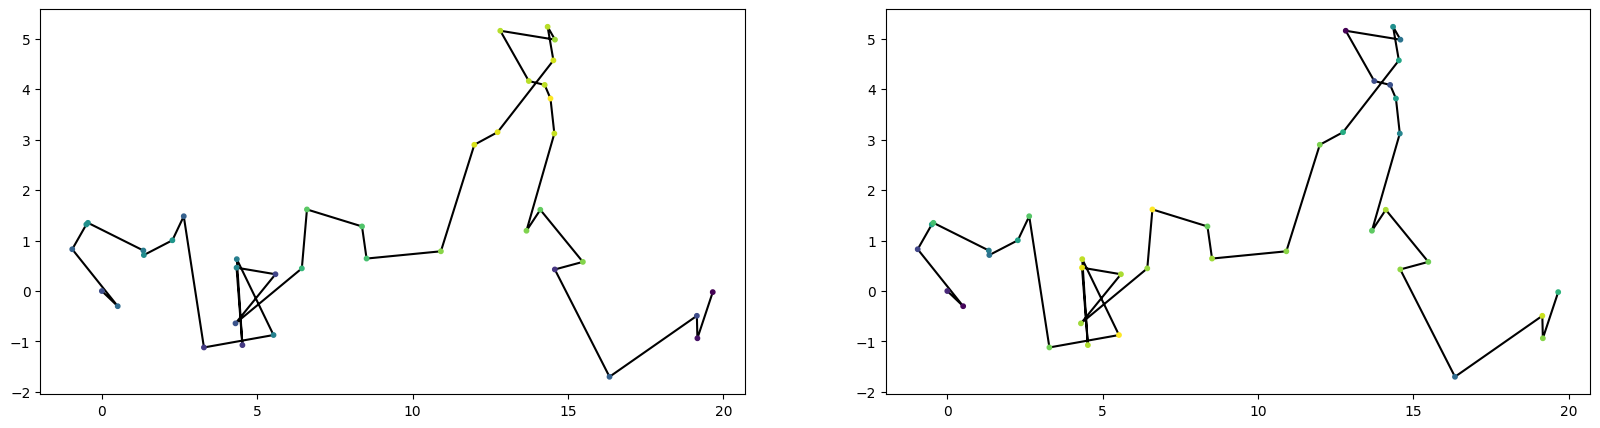

In [53]:
#Representation of values in space
#colors = torch.cat(pred_a).numpy()
#x_coords = torch.cat([traj[1] for traj in all_trajectories]).numpy()
#y_coords = torch.cat([traj[0] for traj in all_trajectories]).numpy()
idx = 2
colors1 = (pred_a[idx].numpy())[:-1]
colors2 = pred_d[idx].numpy()
x_coords = (all_trajectories[idx][0].numpy())[:-1]
y_coords = (all_trajectories[idx][1].numpy())[:-1]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(x_coords, y_coords, color='black', zorder=1)
axes[0].scatter(x_coords, y_coords, c=colors1, cmap='viridis', s=10)
axes[1].plot(x_coords, y_coords, color='black', zorder=1)
axes[1].scatter(x_coords, y_coords, c=colors2, cmap='viridis', s=10)

In [51]:
#Representation of Dif Coef of one dataset
mean_dif1 = [p.mean().numpy().item() for p in pred_d]
data1 = torch.cat(pred_d).numpy()
data3 = mean_dif1
data2 = np.array(tamsd_dif)
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

AttributeError: 'list' object has no attribute 'min'

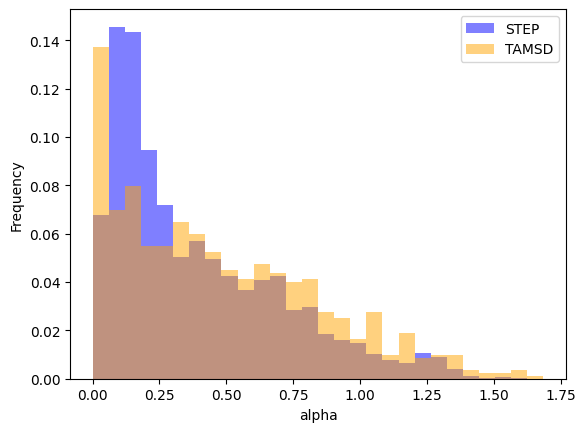

In [21]:
#Representation of alpha of one dataset
data1 = torch.cat(pred_a2).numpy()
data2 = np.array(tamsd_alpha2)
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

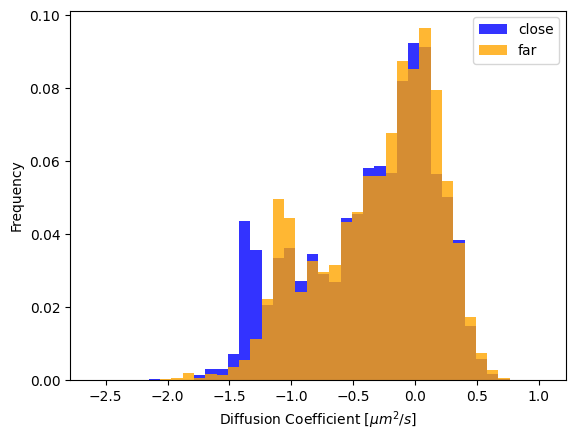

In [23]:
#Filtering of data by close and far, Dif. coef. 
data_close, data_far = [], []
for pred, c in zip(pred_d, all_close):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    close_pred = pred[c < 5]
    far_pred = pred[c > 5]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [40]:
num_values = len(data_close) + len(data_far)
ratio_close = len(data_close)/num_values
ratio_far = len(data_far)/num_values
print(ratio_close, ratio_far)

0.3411597166435405 0.6588402833564595


In [25]:
#Filtering of data by close and far, Dif. coef. 
data_close1, data_close2 = [], []
for pred1, pred2, c1, c2 in zip(pred_d, pred_d2, all_close, all_close2):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred1[-1]
    filled_values = torch.full((len(c1) - len(pred1),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred1 = torch.cat((pred1, filled_values), dim=0)
    last_pred_value = pred2[-1]
    filled_values = torch.full((len(c2) - len(pred2),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred2 = torch.cat((pred2, filled_values), dim=0)
    # Bolean indexing
    close_pred1 = pred1[c1 <= 5]
    close_pred2 = pred2[c2 <= 5]
    #Append the data
    data_close1.append(close_pred1)
    data_close2.append(close_pred2)
data1 = torch.cat(data_close1).numpy()
data2 = torch.cat(data_close2).numpy()

#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylim(0, 0.11)
plt.ylabel('Frequency')
plt.legend()
plt.show()

RuntimeError: Trying to create tensor with negative dimension -23: [-23]

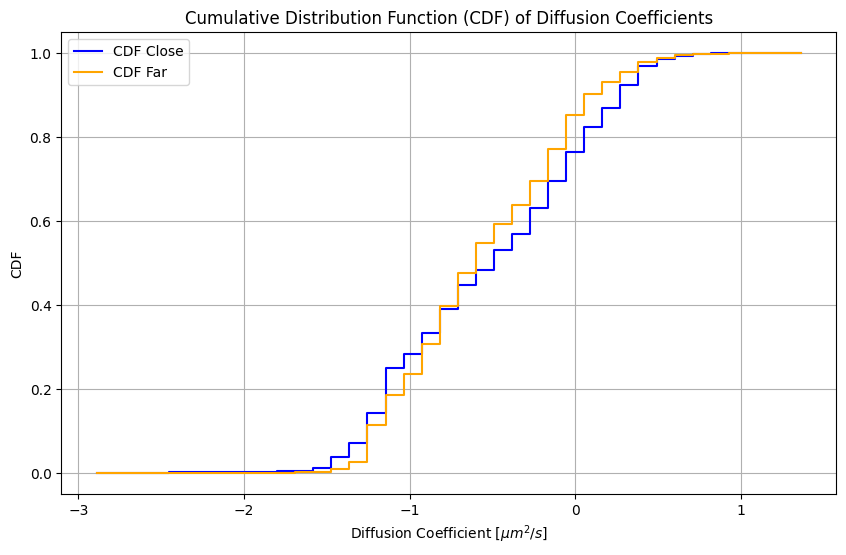

In [25]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

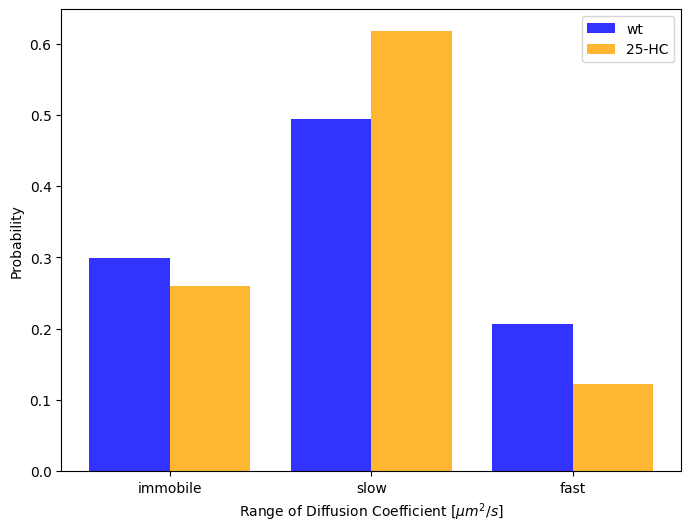

In [26]:
## Ploting bars
# Interpolation of probability values
points = [-1, 0]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [33]:
print(len(all_close2[0]), len(pred_a2[0]))

19 19


In [32]:
#Filtering of data by close and far, alpha
data_close, data_far = [], []
for pred, c in zip(pred_a2, all_close2):
    # Bolean indexing
    close_pred = pred[c < 3]
    far_pred = pred[c > 3]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
#Determine number of bins
data1 = data_close
data2 = data_far
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far', align='edge')
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

IndexError: The shape of the mask [13] at index 0 does not match the shape of the indexed tensor [37] at index 0

In [151]:
## Ridge plot for D vs. MCS

# Flatten the lists of tensors
all_close_flat = np.concatenate([c[:-1].numpy() for c in all_close]) #we eliminate the last value from each traj
all_close_flat *= 0.1567 #multiply by the pixel size (nm)
pred_d_flat = torch.cat(pred_d).numpy()

# Classify the predictions into groups
def classify_predictions(predictions):
    bins = [-3, -1.2, 0, 1]  # The edges of the bins for classification
    group_labels = ['immobile', 'slow', 'fast']
    group_indices = np.digitize(predictions, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(pred_d_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': all_close_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['immobile', 'slow', 'fast'], ordered=True)

In [152]:
from scipy.stats import gaussian_kde
import seaborn as sns

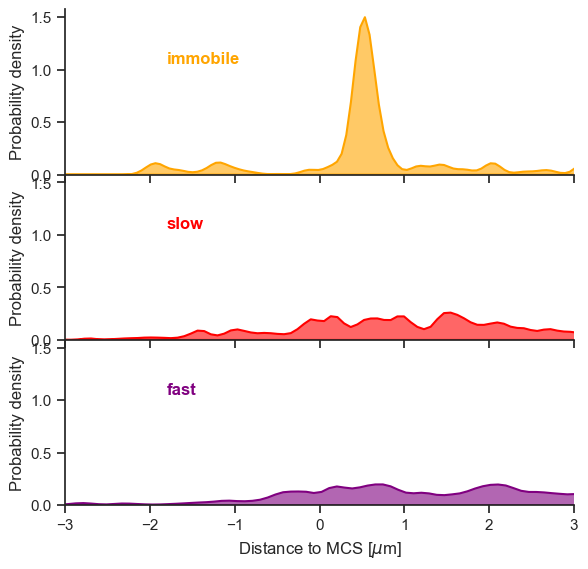

In [153]:
# Set up the matplotlib figure
custom_palette = {
    'immobile': 'orange', 
    'slow': 'red',    
    'fast': 'purple'  
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('Distance to MCS [$\mu$m]')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis

# x-axis limits
for ax in g.axes.flat:
    ax.set_xlim(-3, 3)
    
plt.show()

In [33]:
## Ridge plot, classification by proximity to MCS
# Classify the predictions into groups
def classify_predictions(distance):
    bins = [-20, 0, 5, 20]  # The edges of the bins for classification
    group_labels = ['very close', 'close', 'far']
    group_indices = np.digitize(distance, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(all_close_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': pred_d_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['very close', 'close', 'far'], ordered=True)

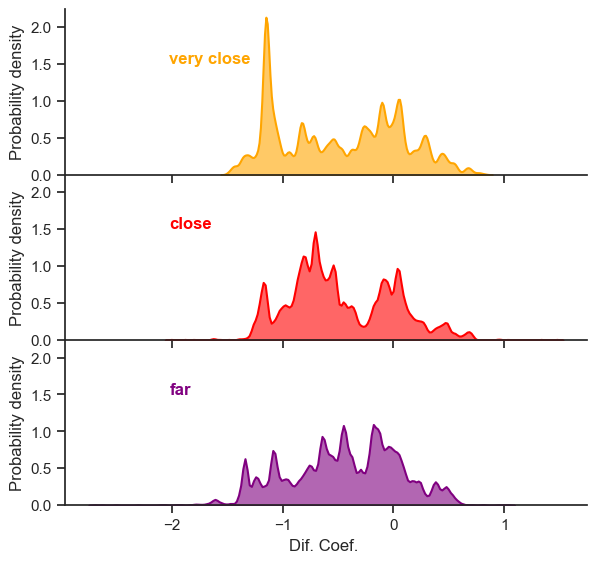

In [34]:
# Set up the matplotlib figure
custom_palette = {
    'very close': 'orange',
    'close': 'red',   
    'far': 'purple' 
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('Dif. Coef. ')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis
plt.show()

In [119]:
print(len(all_close_flat))
print(len(pred_a_flat))

10789
10789


In [32]:
## Ridge plot for alpha vs. MCS

# Flatten the lists of tensors
all_close_flat = torch.cat(all_close).numpy()
pred_a_flat = torch.cat(pred_a).numpy()

# Classify the predictions into groups
def classify_predictions(distance):
    bins = [0, 2, 10, 30]  # The edges of the bins for classification
    group_labels = ['very close', 'close', 'far']
    group_indices = np.digitize(distance, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(all_close_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': pred_a_flat,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['very close', 'close', 'far'], ordered=True)

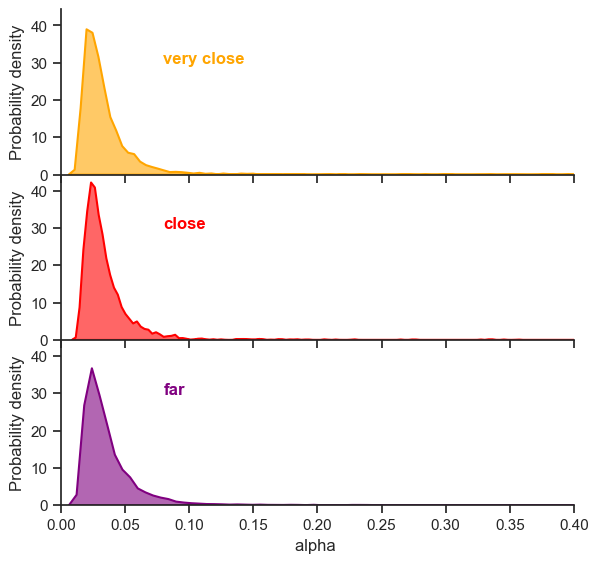

In [33]:
# Set up the matplotlib figure
custom_palette = {
    'very close': 'orange',  # Replace with the actual color you want for Group 1
    'close': 'red',     # Replace with the actual color you want for Group 2
    'far': 'purple'   # Replace with the actual color you want for Group 3
}
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the FacetGrid. 'row' should be the name of the DataFrame column that contains the group names.
g = sns.FacetGrid(df, row='Group', hue='Group', aspect=3, height=2,
                  palette=custom_palette)

# Binning
total_data_points = len(df['Value'])  # Total number of data points across all groups
num_bins = int(np.sqrt(total_data_points))

g.map(sns.kdeplot, 'Value', clip_on=True, fill=True, alpha=0.6, lw=1.5, bw_adjust=0.2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.2, .7, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "Value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axis titles and ticks
g.set_titles("")
g.set_xlabels('alpha ')
g.set_ylabels('Probability density')

# Despine and show the plot
g.despine(bottom=False, left=False)  # Keep the left spine for the y-axis
for ax in g.axes.flat:
    ax.set_xlim(0, 0.4)
plt.show()

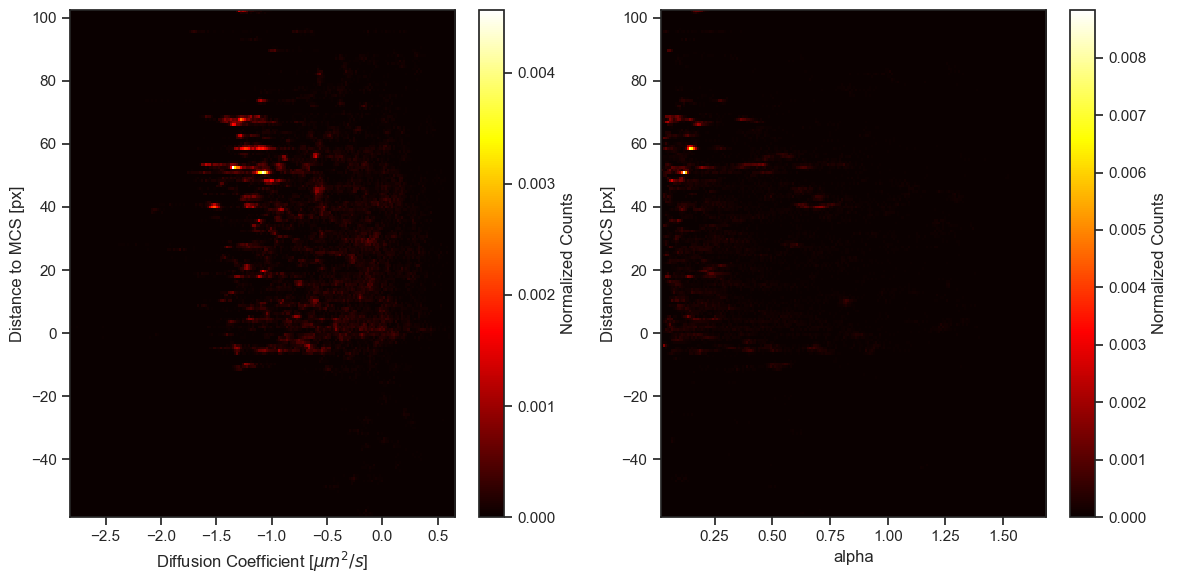

In [35]:
#Representation D and alpha vs. distance to MCS
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d2, pred_a2):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close2).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_bin_size + 1)]

#Plot
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
total_data_points = np.sum(hist_2d_2)
hist_2d_normalized2 = hist_2d_2 / total_data_points
im2 = axs[1].imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
#axs[1].set_ylim(-10,10)
#axs[0].set_ylim(-10,10)
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

Text(0, 0.5, 'Mean Alpha')

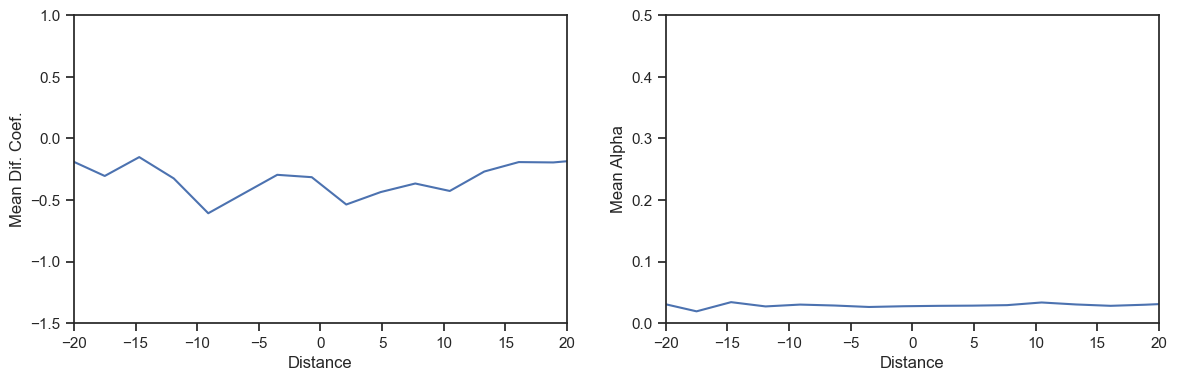

In [68]:
## Mean Dif and alpha for each distance
# Define bins for data2 values
num_bins = 60
bins = np.linspace(data2.min(), data2.max(), num_bins + 1)
bin_midpoints = (bins[:-1] + bins[1:]) / 2  # Calculate midpoints of bins for x-axis in plots


# Assign each data2 value to a bin
bin_indices = np.digitize(data2, bins)

# Create a DataFrame for easy calculation
df = pd.DataFrame({
    'Dif. coef.': data1,
    'alpha': data3,
    'distances': data2,
    'bin_index': bin_indices
})
df = df[df['bin_index'] < len(bins)] #remove last bin

# Calculate the mean prediction for each bin
mean_dif = df.groupby('bin_index')['Dif. coef.'].median()
mean_alpha = df.groupby('bin_index')['alpha'].median()

# Optional: Create a more readable output by associating bin ranges with the means
#bin_ranges = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
#mean_predictions_readable = mean_predictions_per_bin.rename(index=dict(zip(range(1, len(bins)), bin_ranges)))
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(bin_midpoints, mean_dif.values)
axes[0].set_ylim(-1.5, 1)
axes[0].set_xlim(-20, 20)
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Mean Dif. Coef.')
axes[1].plot(bin_midpoints, mean_alpha.values)
axes[1].set_ylim(0, 0.5)
axes[1].set_xlim(-20, 20)
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Mean Alpha')

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_29872\280341165.py:43: RuntimeWarning: invalid value encountered in divide
  hist_2d_normalized2 = hist_2d_2 / total_data_points


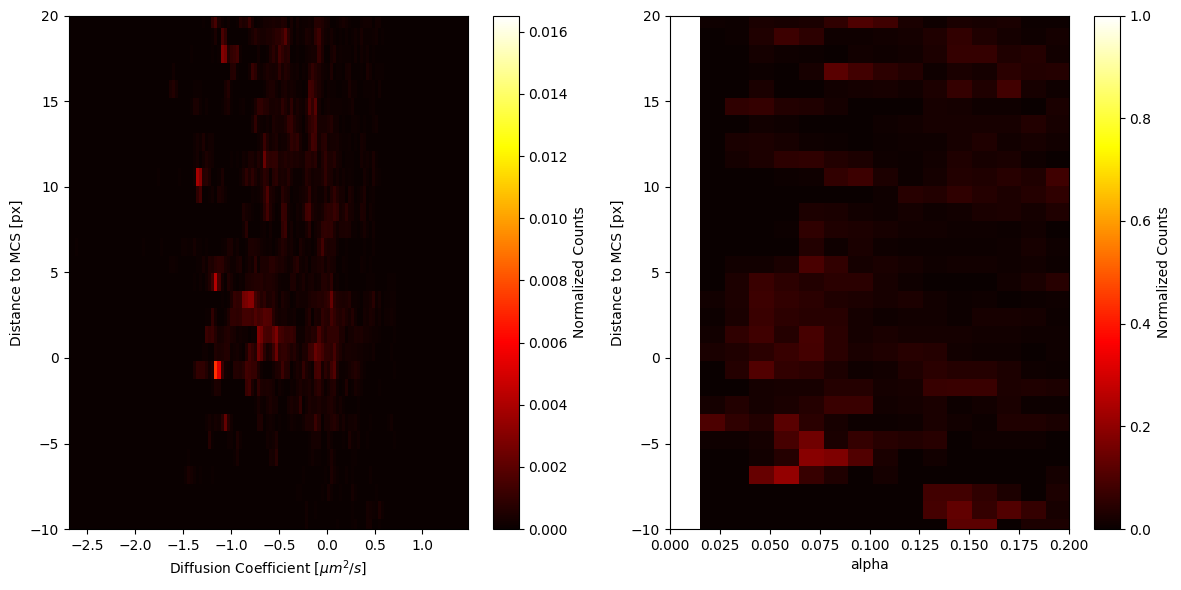

In [25]:
#Representation D and alpha vs. distance to MCS
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d2, pred_a2):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close2).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_bin_size + 1)]

#Plot
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
im1 = axs[0].imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
axs[0].set_ylim(-10,20)
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
#total_data_points = np.sum(hist_2d_2)
total_data_points = hist_2d_2.sum(axis=1, keepdims=True) #total values per row
hist_2d_normalized2 = hist_2d_2 / total_data_points
im2 = axs[1].imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
axs[1].set_ylim(-10,20)
axs[1].set_xlim(0,0.2)
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

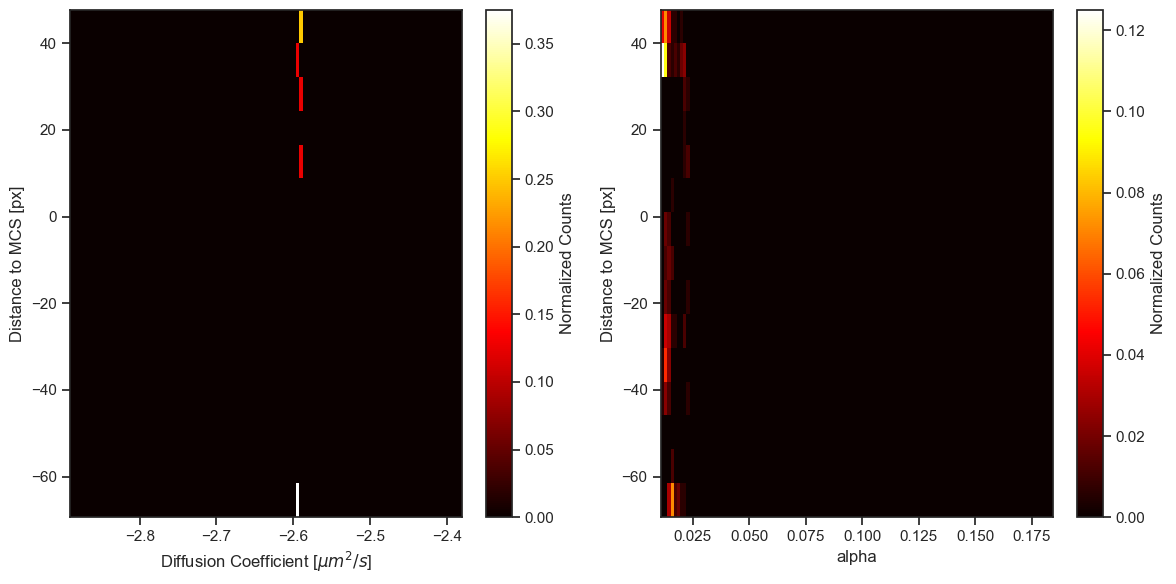

In [28]:
#Representation D and alpha vs. distance to MCS (subset)
# Process data
data1, data3 = [], []
for pred, pred2 in zip(pred_d, pred_a):
    # Duplicate the last value of pred
    last_pred_value1 = pred[-1].unsqueeze(0)
    pred = torch.cat((pred, last_pred_value1), dim=0)
    #Concatenate
    data1.append(pred)
    data3.append(pred2)
data1 =  torch.cat(data1).numpy()
data2 = torch.cat(all_close).numpy()
data3 = torch.cat(data3).numpy()

# Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
chosen_num = min(num_bins1, num_bins2, num_bins3)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
data3_range = (min(data3), max(data3))
bins1 = [np.linspace(data2_range[0], data2_range[1], chosen_num + 1), 
        np.linspace(data1_range[0], data1_range[1], chosen_num + 1)]
bins2 = [np.linspace(data2_range[0], data2_range[1], chosen_num + 1), 
        np.linspace(data3_range[0], data3_range[1], chosen_num + 1)]

# Plot the subset with adjusted intensity
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins1)
hist_subset = hist_2d_1.[0:15,:]
total_data_points = np.sum(hist_subset)
hist_subset = hist_subset / total_data_points
vmin_subset, vmax_subset = hist_subset.min(), hist_subset.max()
im1 = axs[0].imshow(hist_subset, cmap='hot', interpolation='nearest', origin='lower',
           extent=[yedges[0], yedges[16], xedges[0], xedges[-1]],
           vmin=vmin_subset, vmax=vmax_subset)
axs[0].set_xlabel('Diffusion Coefficient [$\mu m^2/s$]')
axs[0].set_ylabel('Distance to MCS [px]')
axs[0].set_aspect('auto')
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
cbar1.set_label('Normalized Counts')
hist_2d_2, xedges, yedges = np.histogram2d(data2, data3, bins=bins2)
hist_subset2 = hist_2d_2[0:15, :]
total_data_points = np.sum(hist_subset2)
hist_subset2 = hist_subset2 / total_data_points
vmin_subset, vmax_subset = hist_subset2.min(), hist_subset2.max()
im2 = axs[1].imshow(hist_subset2, cmap='hot', interpolation='nearest', origin='lower',
           extent=[yedges[0], yedges[16], xedges[0], xedges[-1]],
           vmin=vmin_subset, vmax=vmax_subset)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Distance to MCS [px]')
axs[1].set_aspect('auto')
cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')
cbar2.set_label('Normalized Counts')
plt.tight_layout()

In [24]:
num_bins

122

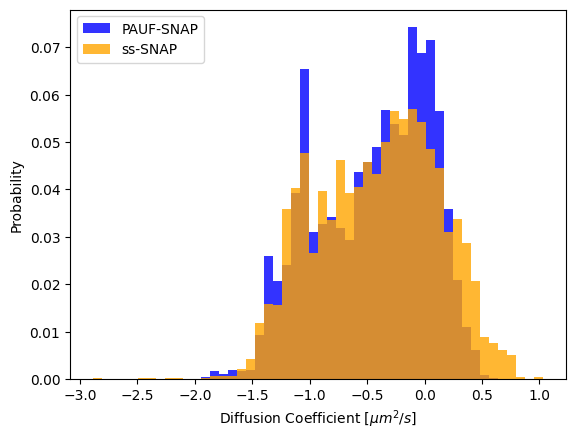

In [22]:
#Representation of both datasets
data1 = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 50
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

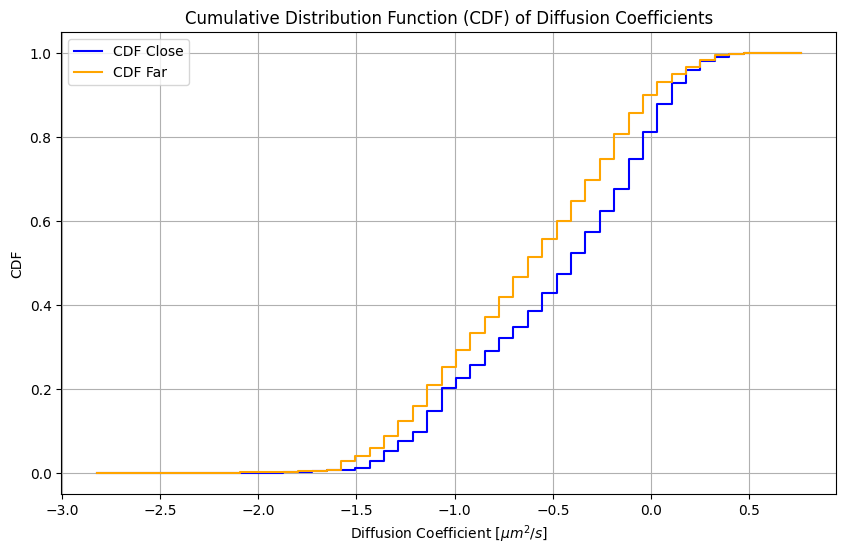

In [33]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 5 #adjust based on your data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.28619797 -1.13979697]
Significant ranges for 'far': []


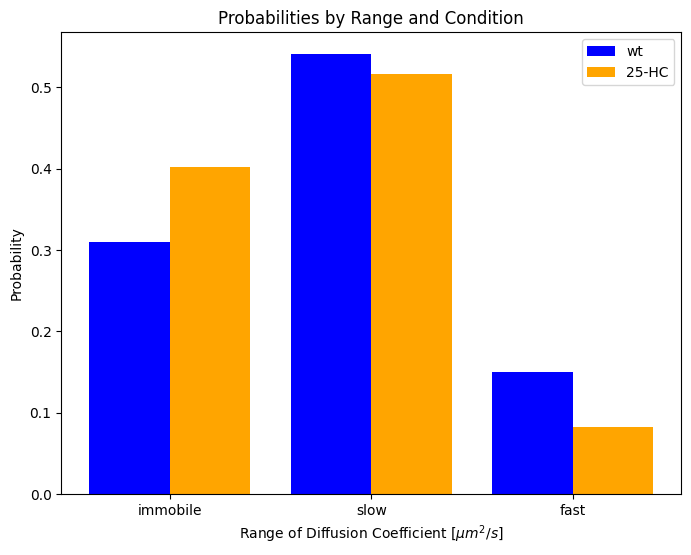

In [34]:
## PLoting bars
# Interpolation of probability values
points = [-0.8, 0]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient [$\mu m^2/s$]')
ax.set_ylabel('Probability')
ax.set_title('Probabilities by Range and Condition')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

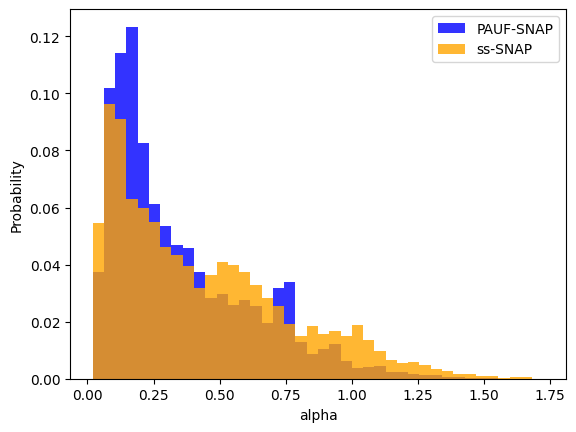

In [24]:
#Representation of both datasets
data1 = torch.cat(pred_a).numpy()
data2 = torch.cat(pred_a2).numpy()
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

In [25]:
## Calculating the mean value for te whole trajectory
mean_dif1 = [p.mean().numpy().item() for p in pred_d]
mean_dif2 = [p.mean().numpy().item() for p in pred_d2]
mean_alpha1 = [p.mean().numpy().item() for p in pred_a]
mean_alpha2 = [p.mean().numpy().item() for p in pred_a2]

In [26]:
#Representation of both datasets
data1 = np.array(mean_dif1)
data1 = np.array(mean_dif2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

NameError: name 'data2' is not defined

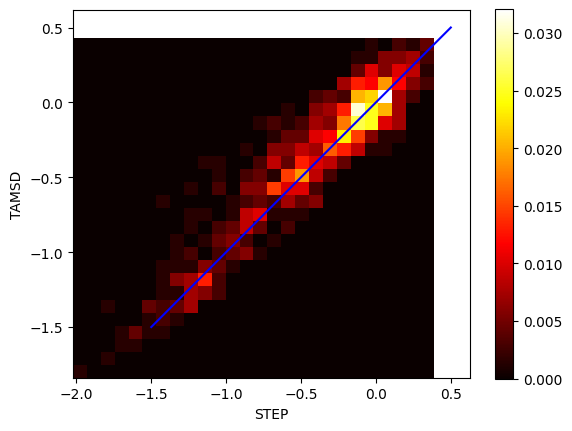

In [27]:
## Heat map STEP vs. TAMSD
# Process data
data1 = mean_dif1
data2 = tamsd_dif

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(-1.5,0.5,2), np.linspace(-1.5,0.5,2), color='blue')

In [73]:
## Heat map STEP vs. TAMSD
# Process data
data1 = mean_alpha1
data2 = tamsd_alpha

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(0,0.2,5), np.linspace(0,0.2,5), color='blue')

NameError: name 'mean_alpha1' is not defined

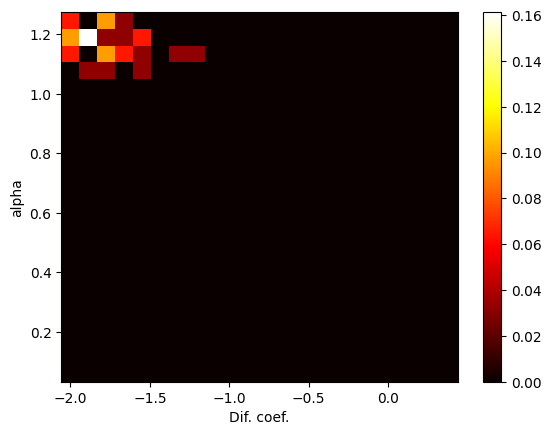

In [31]:
# Relationship diff. coef. and alpha
# Process data
data1 = np.array(mean_dif2)
data2 = np.array(mean_alpha2)

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(num_bins1, num_bins2)
data1_range = (min(data1), max(data1))
data2_range = (min(data2), max(data2))
bins = [np.linspace(data1_range[0], data1_range[1], chosen_bin_size + 1), 
        np.linspace(data2_range[0], data2_range[1], chosen_bin_size + 1)]

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
#total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized = hist_2d_1 / total_data_points
hist_2d_normalized[np.isnan(hist_2d_normalized)] = 0 #replace NaNs with 0 (to avoid division by zero)

#Plot
#plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.8)
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
#plt.ylim(0, data_range[1])
plt.colorbar()

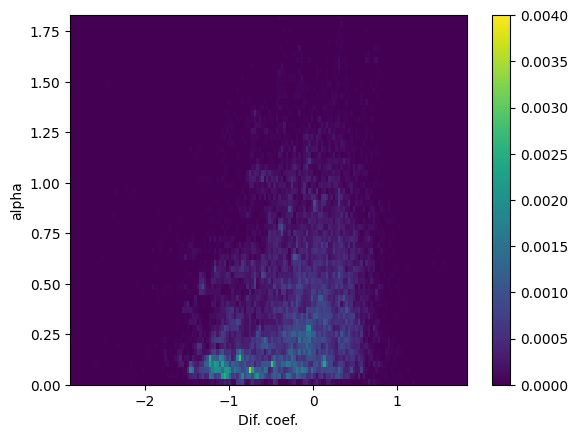

In [98]:
# Relationship diff. coef. and alpha
# Process data
data3 = torch.cat(pred_d2).numpy()
modified_tensors = [tensor[:-1] for tensor in pred_a2] #eliminate the last value
data4 = torch.cat(modified_tensors).numpy()
data1 = torch.cat(pred_d).numpy()
modified_tensors2 = [tensor[:-1] for tensor in pred_a] #eliminate the last value
data2 = torch.cat(modified_tensors2).numpy()

# Define the number of bins for each variable
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
chosen_bin_size = min(num_bins1, num_bins2, num_bins3, num_bins4)
data_range = [min(data1.min(), data2.min(), data3.min(), data4.min()), max(data1.max(), data2.max(), data3.max(), data4.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_1)
#total_data_points = hist_2d_1.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized1 = hist_2d_1 / total_data_points

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)

# Normalization
total_data_points = np.sum(hist_2d_2)
#total_data_points = hist_2d_2.sum(axis=1, keepdims=True)  # Sum across rows
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Subtraction of the histograms
hist_2d_diff = hist_2d_2 - hist_2d_1

#Plot
plt.imshow(hist_2d_normalized1, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.004)
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

In [27]:
print("Length of all_trajectories[0]:", len(all_trajectories[0]))
print("Length of all_trajectories[1]:", len(all_trajectories[1]))

Length of all_trajectories[0]: 2
Length of all_trajectories[1]: 2


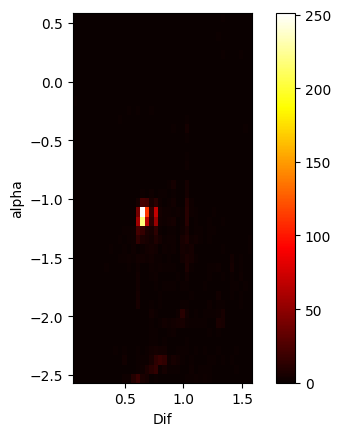

In [40]:
filtered_pred_d = []
filtered_pred_a = []
filtered_trajectories_x, filtered_trajectories_y = [], []

for d, a, traj in zip(pred_d, pred_a, all_trajectories):
    if torch.any(d < -1.2) and torch.any(a > 0.6):
        filtered_pred_d.append(d)
        filtered_pred_a.append(a[:-1])
        filtered_trajectories_x.append(traj[0][:-1])
        filtered_trajectories_y.append(traj[1][:-1])
# Process data
data1 = torch.cat(filtered_pred_d).numpy()
data2 = torch.cat(filtered_pred_a).numpy()

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('Dif')
plt.ylabel('alpha')
plt.colorbar()

# Prediction examples

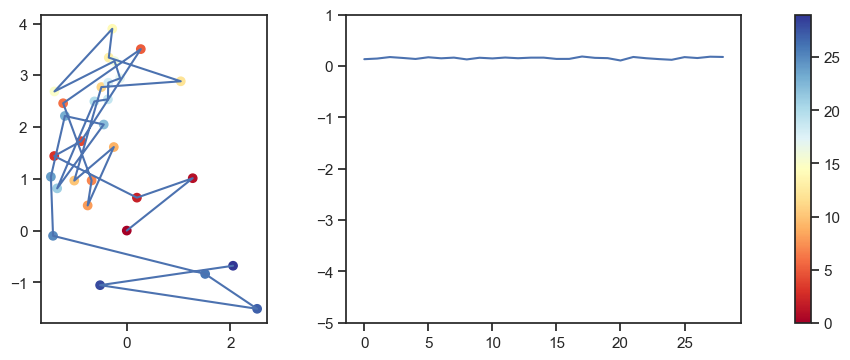

In [97]:
idx = 13
traj = all_trajectories[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_d[idx])
axes[1].set_ylim(-5, 1)
axes[0].set_aspect('equal')

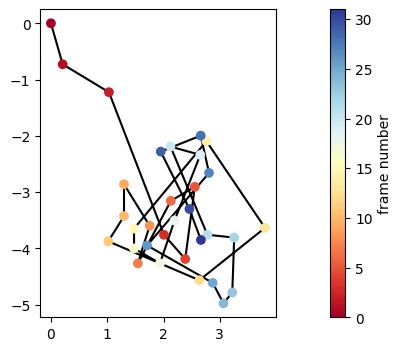

In [180]:
idx = 6
traj = all_trajectories2[idx]
plt.figure(figsize=(14, 4))
plt.plot(traj[0], traj[1], color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame number')
plt.gca().set_aspect('equal')

In [28]:
t_lag = [1, 2, 3, 4]
D_tamsd = (diffusion_coefficient_tamsd(tensor(traj).T, t_lag))
print(D_tamsd)

0.22330986559391022


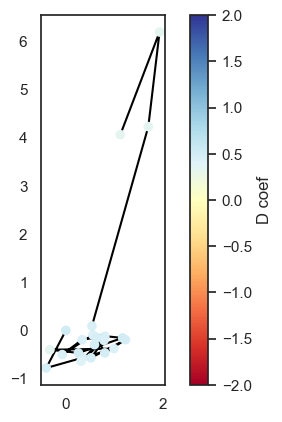

In [128]:
# Dif coef
idx = 32
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_d2[idx][-1]
preds_idx_extended = np.append(pred_d2[idx], np.full(len(x) - len(pred_d2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

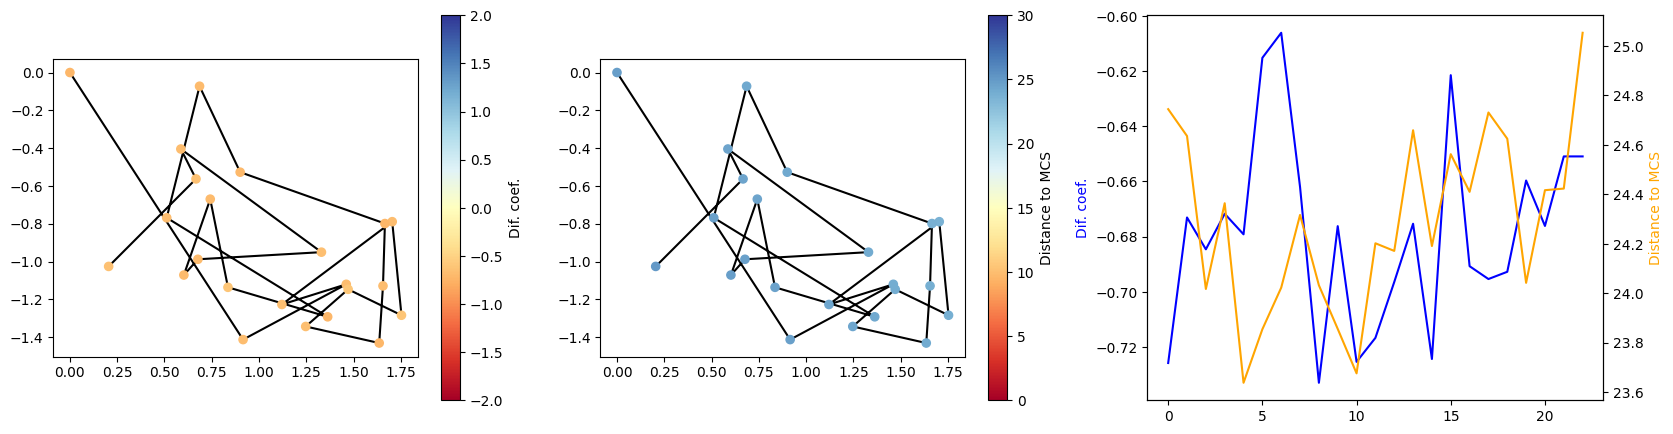

In [32]:
idx = 16
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_d[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_d[idx], np.full(len(x) - len(pred_d[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Dif. coef.')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS')
axes[2].set_ylabel('Dif. coef.', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

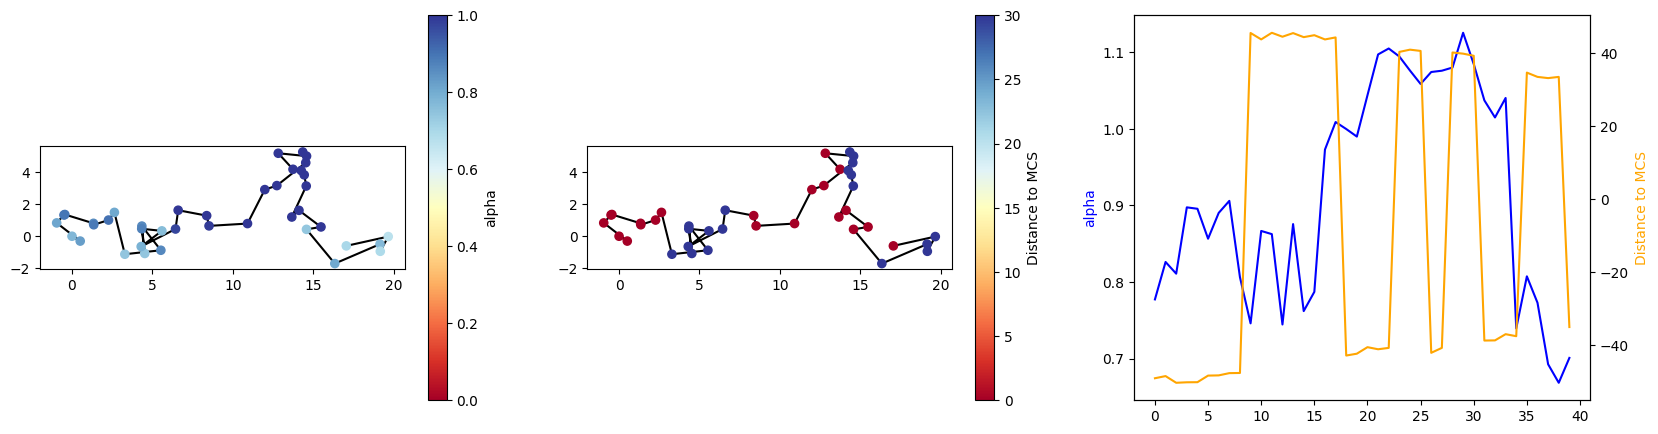

In [54]:
idx = 2
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
last_pred_value = pred_a[idx][-1] # Duplicate the last value of preds to match the length of x and y
preds_idx_extended = np.append(pred_a[idx], np.full(len(x) - len(pred_a[idx]), last_pred_value))
close = all_close[idx]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=1)
sc2 = axes[1].scatter(x, y, c=close, s=35, cmap=cm1, zorder=2, vmin=0, vmax=30)
axes2_twin = axes[2].twinx()
axes[2].plot(preds_idx_extended, color='blue')
axes2_twin.plot(close, color='orange')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('alpha')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Distance to MCS')
axes[2].set_ylabel('alpha', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

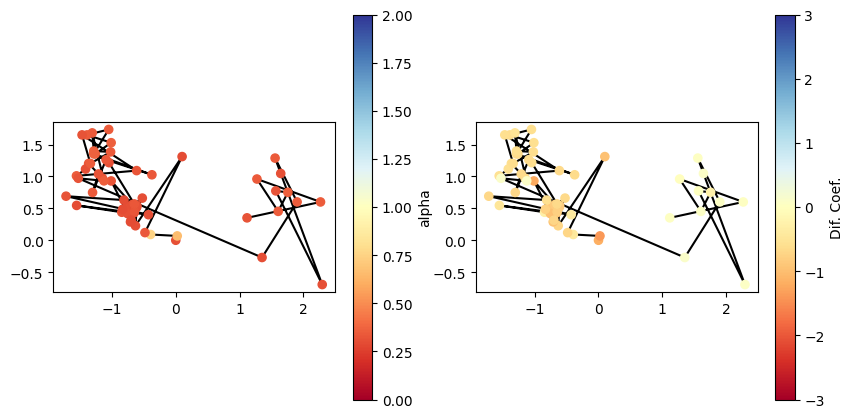

In [44]:
idx = 8
x = (filtered_trajectories_x[idx].numpy())
y = (filtered_trajectories_y[idx].numpy())
preds_idx1 = (filtered_pred_a[idx].numpy())
preds_idx2 = filtered_pred_d[idx].numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cm1 = matplotlib.colormaps['RdYlBu']
axes[0].plot(x, y, color='black', zorder=1)
axes[1].plot(x, y, color='black', zorder=1)
sc1 = axes[0].scatter(x, y, c=preds_idx1, s=35, cmap=cm1, zorder=2, vmin=0, vmax=2)
sc2 = axes[1].scatter(x, y, c=preds_idx2, s=35, cmap=cm1, zorder=2, vmin=-3, vmax=3)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('alpha')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Dif. Coef.')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

In [53]:
# Alpha
idx = 6
traj = all_trajectories[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_a2[idx][-1]
preds_idx_extended = np.append(pred_a2[idx], np.full(len(x) - len(pred_a2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('alpha')
plt.gca().set_aspect('equal')

ValueError: negative dimensions are not allowed

# Trajectory segmentation

Segmentation only by diffusion coefficient: 

In [23]:
def find_segments(pred, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred) # Only changes in D
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas_tamsd, angles = [], [], [], [], []
    new_d = np.ones_like(pred)
    d_tamsd = np.ones_like(pred)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D_seg = pred[i:j].mean()
        new_d[i:j] *= D_seg
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        d_tamsd[i:j] *= D_tamsd
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)

    return new_d, d_tamsd, segments, Ds, Ds_tamsd, alphas_tamsd, angles

In [54]:
seg_ds, seg_ds_tamsd, seg_angs, trajs, new_Dif, new_tamsd, seg_alphas_tamsd = [], [], [], [], [], [], []
for traj, pred in tqdm(zip(trajectories2, pred_d2)):
    pred1 = pred.numpy()
    pred1 = pred1.T
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments(pred1, traj, min_size=6, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, segments, d_seg, dtamsd_seg, alphas_tamsd, angs = out
    new_Dif.append(new_d)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    trajs.append(segments)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd.append(alphas_tamsd)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\212549062.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


Text(0.5, 0, 'Frame number')

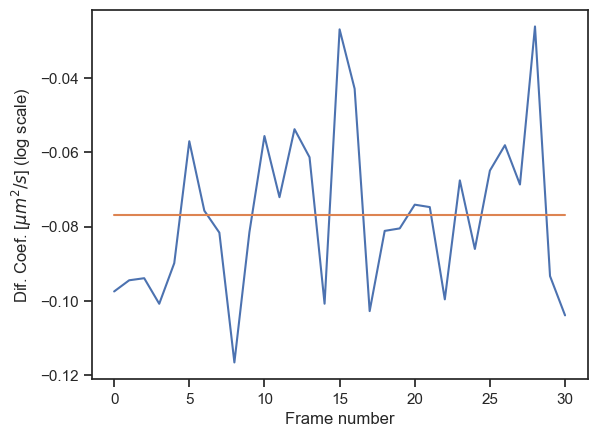

In [69]:
idx = 6
plt.plot(pred_d2[idx])
plt.plot(new_Dif[idx])
plt.ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
plt.xlabel('Frame number')

In [57]:
pred1 = pred_d2[32].numpy()
pred1 = pred1.T
x, y = traj[0], traj[1]
traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
out = find_segments(pred1, traj, min_size=4, pen=2) # previously min_size=10, pen=0.1
new_d, d_tamsd, segments, d_seg, dtamsd_seg, alphas_tamsd, angs = out
print(d_seg, dtamsd_seg)

[0.4546155] [0.110582259373802]


C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_20460\872114572.py:7: RuntimeWarning: invalid value encountered in divide
  unit_vector_2 = vector_2 / np.linalg.norm(vector_2)


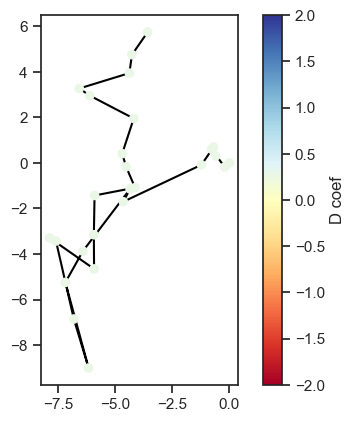

In [60]:
# Select trajectory
idx = 50
traj = trajectories2[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = new_Dif[idx][-1]
preds_idx_extended = np.append(new_Dif[idx], np.full(len(x) - len(new_Dif[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-2, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

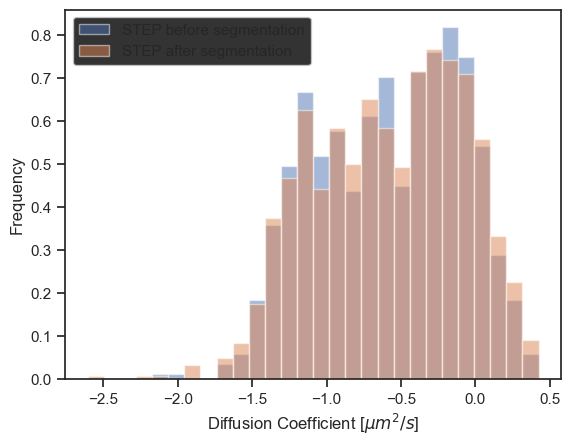

In [82]:
# Representation
data1 = np.array(mean_dif2)
data2 = np.array(seg_ds)
data3 = np.array(tamsd_dif)
data4 = np.array(seg_ds_tamsd)
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins3 = int(np.sqrt(len(data3)))
num_bins4 = int(np.sqrt(len(data4)))
num_bins = min(num_bins1, num_bins2, num_bins3, num_bins4)
min_value = min(data1.min(), data2.min(), data3.min(), data4.min())
max_value = max(data1.max(), data2.max(), data3.max(), data4.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
#Compute histograms
hist1, _ = np.histogram(data1, bins=bin_edges, density=True)
hist2, _ = np.histogram(data2, bins=bin_edges, density=True)
hist3, _ = np.histogram(data3, bins=bin_edges, density=True)
hist4, _ = np.histogram(data4, bins=bin_edges, density=True)
# Plot the histograms
plt.bar(bin_edges[:-1], hist1, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='STEP before segmentation')
plt.bar(bin_edges[:-1], hist2, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='STEP after segmentation')
#plt.bar(bin_edges[:-1], hist3, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='TAMSD before sementation')
#plt.bar(bin_edges[:-1], hist4, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='TAMSD after sementation')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [81]:
print(len(mean_dif2),len(tamsd_dif),len(seg_ds))

801 1189 1107


In [25]:
#Filtering of data by close and far, Dif. coef. 
data_close, data_far = [], []
for pred, c in zip(new_Dif, all_close):
    # Duplicate the last value of pred to match the length of c
    last_pred_value = pred[-1]
    filled_values = np.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype)
    pred = np.concatenate((pred, filled_values), axis=0)
    # Boolean indexing
    close_pred = pred[c <= 5]
    far_pred = pred[c > 5]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
num_bins = 50
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.7, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='far')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

TypeError: Cannot interpret 'torch.float32' as a data type

In [101]:
print(len(data1), len(data2))

9343 18043


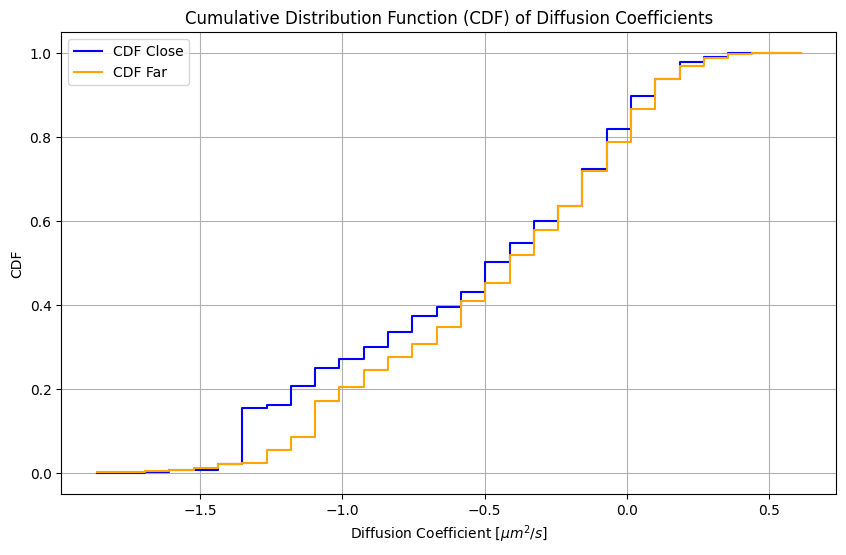

In [49]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 7 #adjust based on your data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.52251824 -1.43717922 -0.32777196]
Significant ranges for 'far': [-1.26650118]


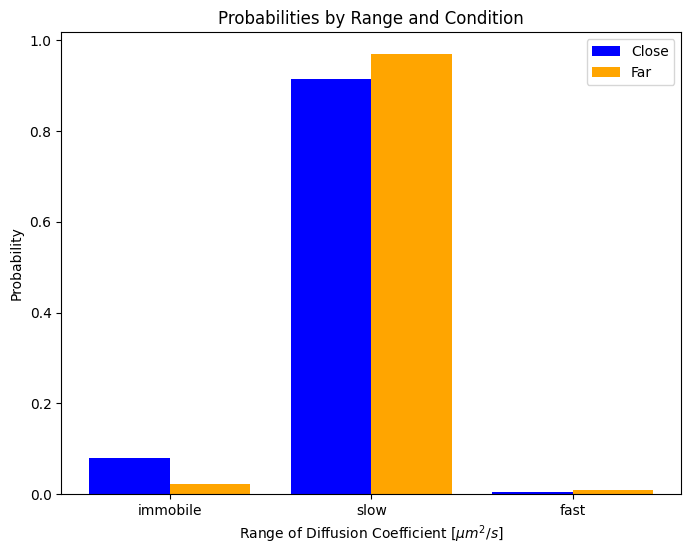

In [73]:
## Ploting bars
# Interpolation of probability values
points = [-1.4, 0.3]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, label='Close', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, label='Far', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient [$\mu m^2/s$]')
ax.set_ylabel('Probability')
ax.set_title('Probabilities by Range and Condition')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

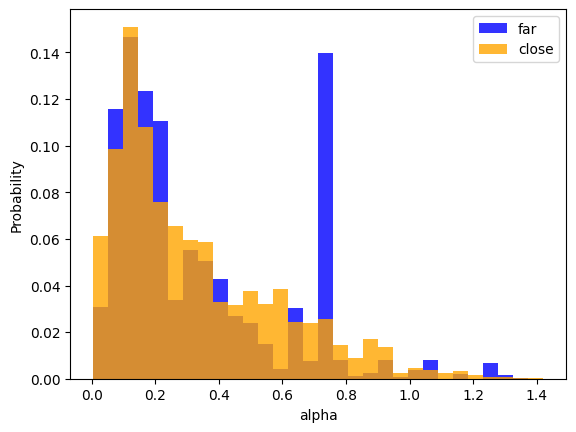

In [44]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(new_alpha, all_close):
    # Duplicate the last value of pred to match the length of c
    last_pred_value = pred[-1]
    filled_values = np.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype)
    pred = np.concatenate((pred, filled_values), axis=0)
    # Boolean indexing
    close_pred = pred[c <= 5]
    far_pred = pred[c > 5]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
#num_bins = min(num_bins1, num_bins2)
num_bins = 30
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

Segmentation by both dif coef and alpha

In [81]:
def find_segments2(pred1, pred2, traj, close, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.column_stack((pred1, pred2)) #concatenate pred_d and pred_alpha
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position, angles = [], [], [], [], [], [], []
    new_d, new_a = np.ones_like(pred1), np.ones_like(pred2)
    d_tamsd = np.ones_like(pred1)
    for i, j in zip(cps[:-1], cps[1:]): #iterate over each segment defined by consecutive cps
        segment = traj[:, i:j]
        alpha_seg, D_seg, loc = pred2[i:j].mean(), pred1[i:j].mean(), close[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        #Fit the MSD curve
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value.numpy()
        a = parameters[1]
        d_tamsd[i:j] *= D_tamsd
        segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)
        position.append(loc)
        if np.abs(i-j) > 0:
            angl = (dataset_angles([segment])) #angle distribution
            angles.append(angl)
            
    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, alphas_tamsd, position, angles

In [82]:
seg_ds, seg_ds_tamsd, seg_angs, seg_alphas, trajs, new_Dif, new_alpha, new_tamsd, seg_alphas_tamsd, jumps_dif, jumps_alpha, location, cps_location = [], [], [], [], [], [], [], [], [], [], [], [], []
for traj, pred1, pred2, close in tqdm(zip(all_trajectories, pred_d, pred_a, all_close)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    traj = np.concatenate([np.zeros((2, 1)), np.array([traj[0], traj[1]])], axis=1)
    out = find_segments2(pred1, pred2, traj, close, min_size=4, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, position, angles = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    trajs.append(segments)
    seg_alphas.append(alphas)
    location.append(position)
    #Calculate changepoint diff and location
    diff_d = np.diff(new_d)  # Successive differences in new_d
    diff_a = np.diff(new_a)  # Successive differences in new_a
    jump_indices_d = np.where(np.abs(diff_d) > 0)[0]  # Indices of jumps in new_d
    jump_indices_a = np.where(np.abs(diff_a) > 0)[0]  # Indices of jumps in new_a
    jump_d = diff_d[jump_indices_d]
    jump_a = diff_a[jump_indices_d]
    cps_loc = close[jump_indices_d + 1]
    cps_location.append(cps_loc)
    jumps_dif.append(jump_d)
    jumps_alpha.append(jump_a)
    seg_angs.append(angles)

seg_ds = np.concatenate(seg_ds)
location = np.concatenate(location)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas = np.concatenate(seg_alphas)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]
jumps_dif = np.concatenate(jumps_dif)
jumps_alpha = np.concatenate(jumps_alpha)
cps_location = np.concatenate(cps_location)

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\1334397792.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


In [83]:
seg_ds2, seg_ds_tamsd, seg_angs2, seg_alphas2, trajs, new_Dif, new_alpha, new_tamsd, seg_alphas_tamsd, jumps_dif2, jumps_alpha2, location2, cps_location2 = [], [], [], [], [], [], [], [], [], [], [], [], []
for traj, pred1, pred2, close in tqdm(zip(all_trajectories2, pred_d2, pred_a2, all_close2)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    traj = np.concatenate([np.zeros((2, 1)), np.array([traj[0], traj[1]])], axis=1)
    out = find_segments2(pred1, pred2, traj, close, min_size=4, pen=0.5) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, position, angles = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds2.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    trajs.append(segments)
    seg_alphas2.append(alphas)
    location2.append(position)
    #Calculate changepoint diff and location
    diff_d = np.diff(new_d)  # Successive differences in new_d
    diff_a = np.diff(new_a)  # Successive differences in new_a
    jump_indices_d = np.where(np.abs(diff_d) > 0)[0]  # Indices of jumps in new_d
    jump_indices_a = np.where(np.abs(diff_a) > 0)[0]  # Indices of jumps in new_a
    jump_d = diff_d[jump_indices_d]
    jump_a = diff_a[jump_indices_d]
    cps_loc = close[jump_indices_d + 1]
    cps_location2.append(cps_loc)
    jumps_dif2.append(jump_d)
    jumps_alpha2.append(jump_a)
    seg_angs2.append(angles)

seg_ds2 = np.concatenate(seg_ds2)
location2 = np.concatenate(location2)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas2 = np.concatenate(seg_alphas2)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]
jumps_dif2 = np.concatenate(jumps_dif2)
jumps_alpha2 = np.concatenate(jumps_alpha2)
cps_location2 = np.concatenate(cps_location2)

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_43536\1334397792.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


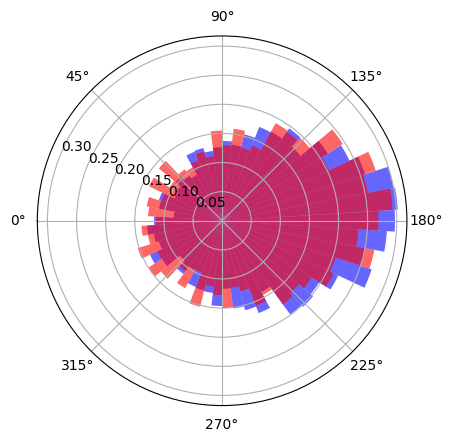

In [25]:
fontsize = 22
ticksize = 16

# Prepare the first dataset
angs1 = np.concatenate([a for ang in seg_angs for a in ang if np.isfinite(a).all()])
angs_rad1 = 2 * np.pi * np.array(angs1) / 360  # Convert degrees to radians
hist1, bins1 = np.histogram(angs_rad1, bins=50, density=True)
width1 = np.diff(bins1)

# Prepare the second dataset
angs2 = np.concatenate([a for ang in seg_angs2 for a in ang if np.isfinite(a).all()])
angs_rad2 = 2 * np.pi * np.array(angs2) / 360  # Convert degrees to radians
hist2, bins2 = np.histogram(angs_rad2, bins=50, density=True)
width2 = np.diff(bins2)

# Create a polar subplot
ax = plt.subplot(111, polar=True)

# Plot the first dataset
bars1 = ax.bar(bins1[:-1], hist1, width=width1, bottom=0.0, color='blue', alpha=0.6, label='Dataset 1')

# Plot the second dataset
bars2 = ax.bar(bins2[:-1], hist2, width=width2, bottom=0.0, color='red', alpha=0.6, label='Dataset 2')

# Set zero degrees to the left and direction of increase
ax.set_theta_zero_location('W')  # Zero degrees at the right
ax.set_theta_direction(-1)  # Clockwise

# Add a legend

# Display the plot
plt.show()

Text(0, 0.5, 'Distance to MCS')

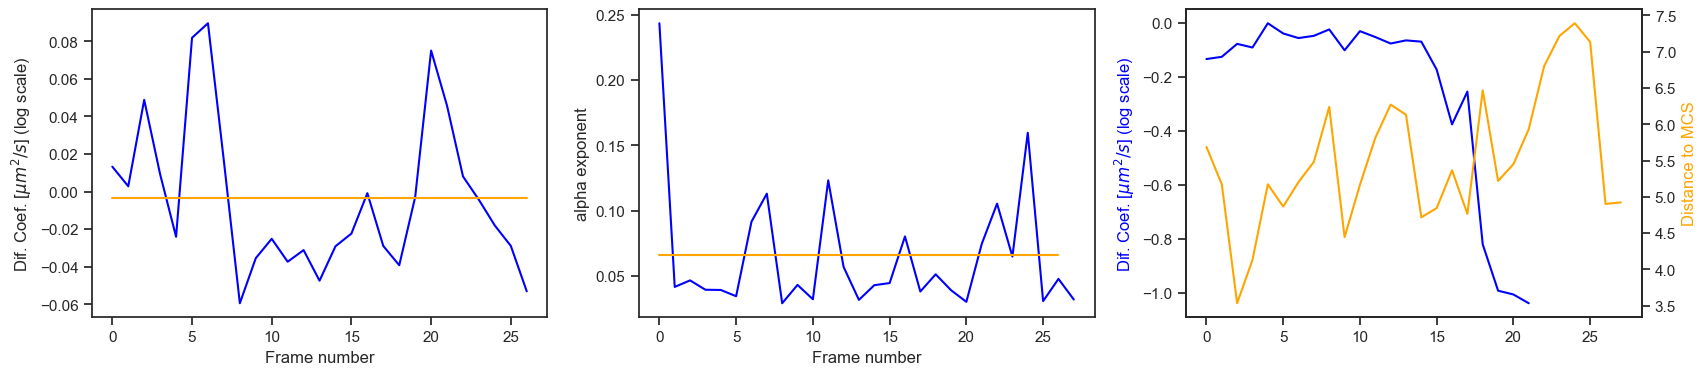

In [35]:
idx = 3
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
axes[0].plot(pred_d2[idx], color='blue')
axes[0].plot(new_Dif[idx], color='orange')
axes[0].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
axes[0].set_xlabel('Frame number')
axes[1].plot(pred_a2[idx], color='blue')
axes[1].plot(new_alpha[idx], color='orange')
axes[1].set_ylabel('alpha exponent')
axes[1].set_xlabel('Frame number')
axes2_twin = axes[2].twinx()
axes[2].plot(pred_d[idx], color='blue')
axes2_twin.plot(all_close2[idx], color='orange')
axes[2].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)', color='blue')
axes2_twin.set_ylabel('Distance to MCS', color='orange')

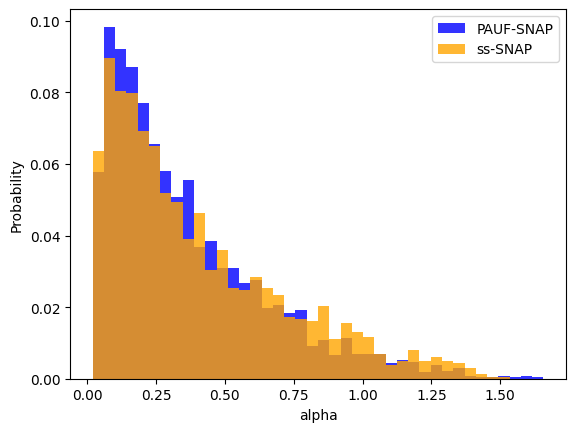

In [26]:
#Representation of both datasets
data1 = np.array(seg_alphas)
data2 = np.array(seg_alphas2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('alpha')
plt.ylabel('Probability')
plt.legend()

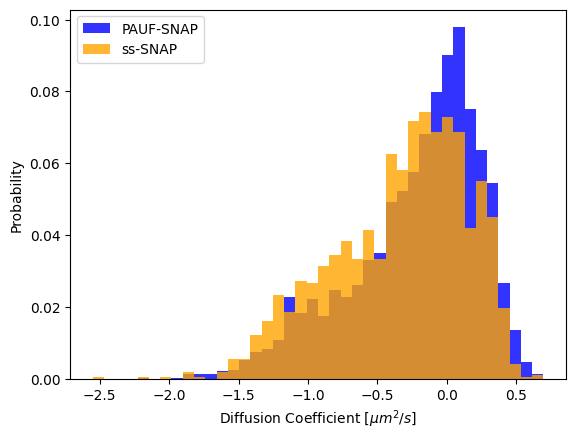

In [27]:
#Representation of both datasets
data1 = np.array(seg_ds)
data2 = np.array(seg_ds2)
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='PAUF-SNAP', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='ss-SNAP', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

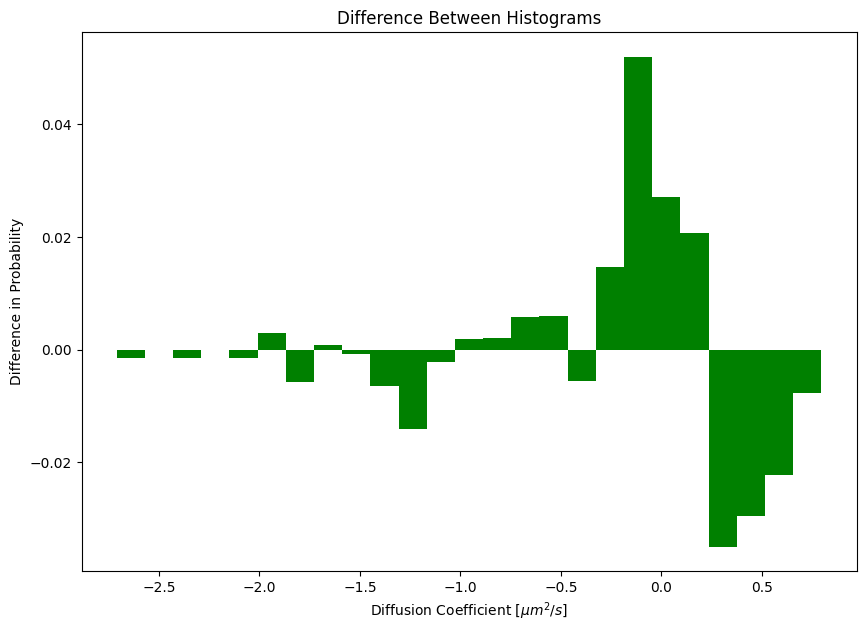

In [32]:
# Plot difference of histograms
plt.figure(figsize=(10, 7))
plt.bar(bin_edges[:-1], relative_probs1 - relative_probs2, width=np.diff(bin_edges), color='green')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Difference in Probability')
plt.title('Difference Between Histograms')
plt.show()

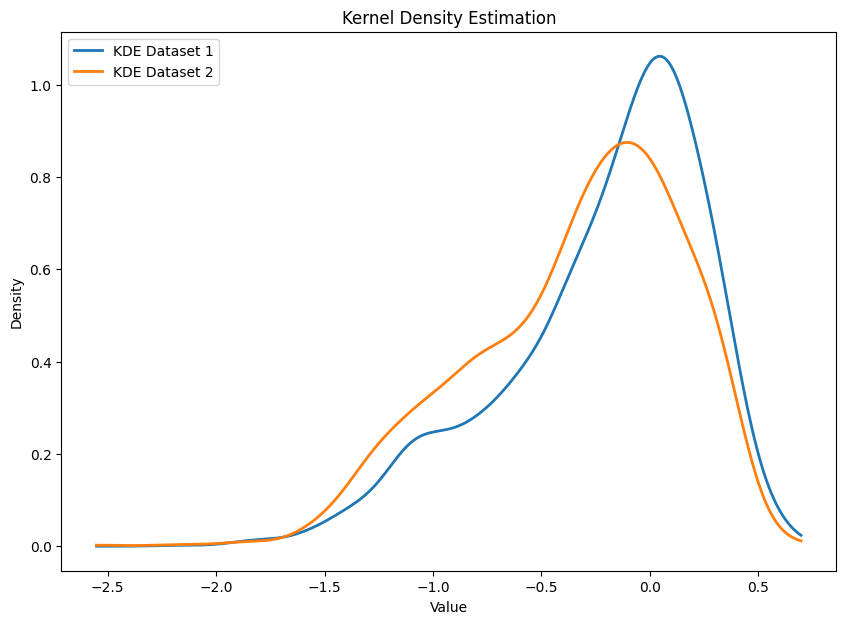

In [29]:
from scipy.stats import gaussian_kde

kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)
values = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.figure(figsize=(10, 7))
plt.plot(values, kde1(values), label='KDE Dataset 1', linewidth=2)
plt.plot(values, kde2(values), label='KDE Dataset 2', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Kernel Density Estimation')
plt.show()

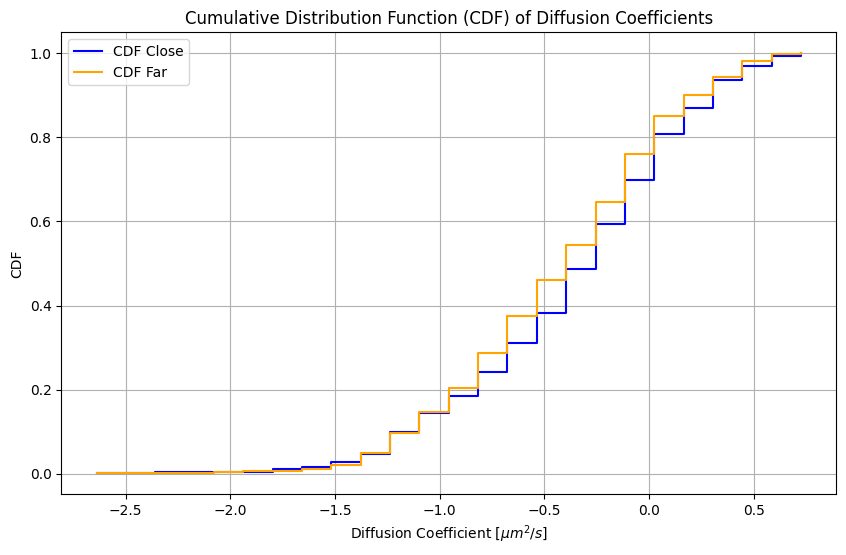

In [25]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Calculate the first derivative (approximate) of the CDFs
first_derivative_close = np.diff(cdf1) / np.diff(bin_edges[:-1])
first_derivative_far = np.diff(cdf2) / np.diff(bin_edges[:-1])

# Calculate the second derivative (approximate) of the CDFs
second_derivative_close = np.diff(first_derivative_close) / np.diff(bin_edges[:-2])
second_derivative_far = np.diff(first_derivative_far) / np.diff(bin_edges[:-2])

# Identifying significant changes
threshold = 1 #adjust based on the data
significant_changes_close = np.where(np.abs(second_derivative_close) > threshold)[0]
significant_changes_far = np.where(np.abs(second_derivative_far) > threshold)[0]

# Translate these indices back to your bin edges to find the ranges
significant_ranges_close = bin_edges[significant_changes_close]
significant_ranges_far = bin_edges[significant_changes_far]

print("Significant ranges for 'close':", significant_ranges_close)
print("Significant ranges for 'far':", significant_ranges_far)

Significant ranges for 'close': [-1.51789948 -0.67670291 -0.1159052   0.16449366]
Significant ranges for 'far': [-1.6580989  -1.09730119 -0.25610463 -0.1159052   0.30469308]


In [28]:
## Ploting bars
# Interpolation of probability values
points = [-0.8, 0.2]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

NameError: name 'cdf1' is not defined

In [23]:
#Filtering of data by close and far, alpha 
data_close1, data_close2 = [], []
for pred1, pred2, c1, c2 in zip(seg_ds, seg_ds2, location, location2):
    # Boolean indexing
    close_pred1 = pred1[c1 <= 5]
    close_pred2 = pred2[c2 <= 5]
    # Append the data
    data_close1.append(close_pred1)
    data_close2.append(close_pred2)
data1 = np.concatenate(data_close1)
data2 = np.concatenate(data_close2)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='wt')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='25-HC')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

NameError: name 'seg_ds' is not defined

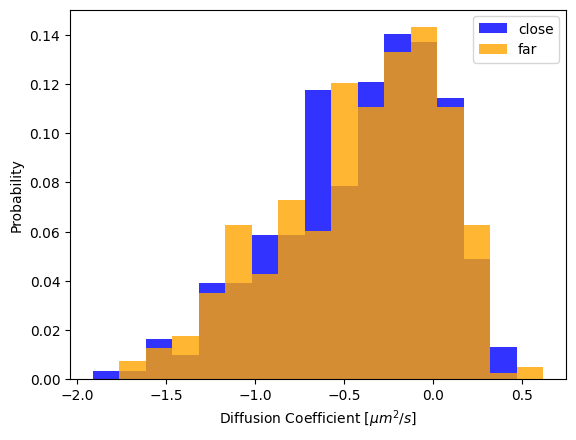

In [105]:
#Filtering of data by close and far, alpha 
data_close, data_far = [], []
for pred, c in zip(seg_ds, location):
    # Boolean indexing
    close_pred = pred[c <= 10]
    far_pred = pred[c > 10]
    # Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data1 = np.concatenate(data_close)
data2 = np.concatenate(data_far)

#Representation close and far 1 dataset
#Binning
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()

# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='blue', label='close')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.8, color='orange', label='far')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Probability')
plt.legend()

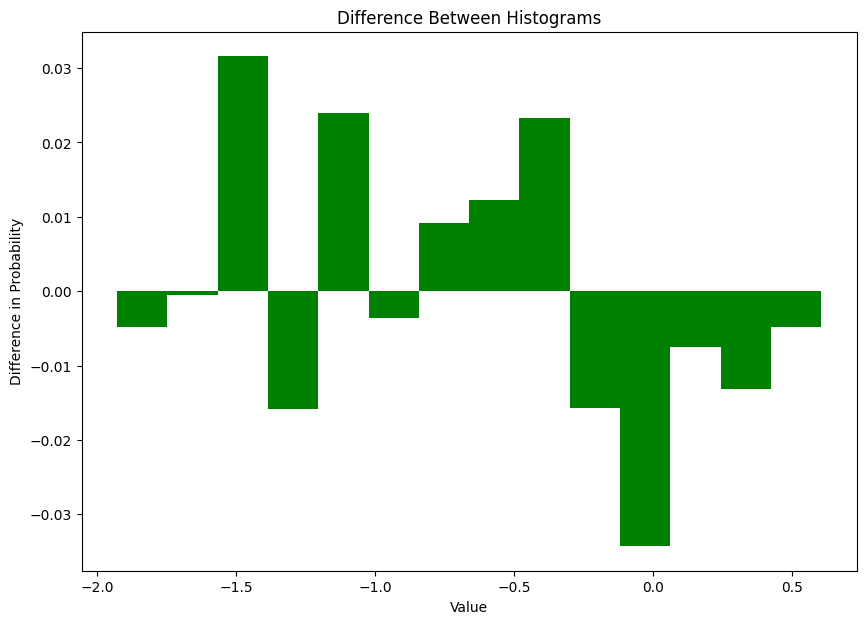

In [33]:
# Plot difference of histograms
plt.figure(figsize=(10, 7))
plt.bar(bin_edges[:-1], relative_probs1 - relative_probs2, width=np.diff(bin_edges), color='green')
plt.xlabel('Value')
plt.ylabel('Difference in Probability')
plt.title('Difference Between Histograms')
plt.show()

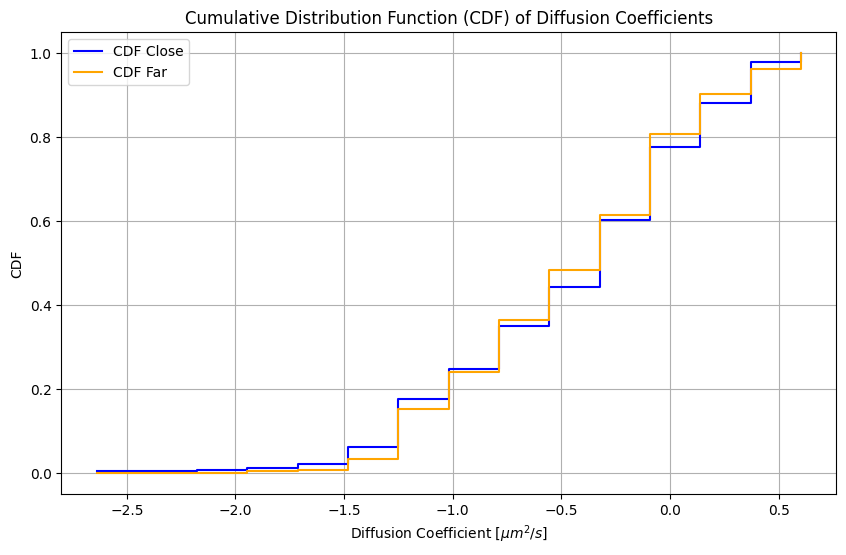

In [35]:
# Compute the CDFs from the relative probabilities
cdf1 = np.cumsum(relative_probs1)
cdf2 = np.cumsum(relative_probs2)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], cdf1, drawstyle='steps-post', label='CDF Close', color='blue')
plt.plot(bin_edges[:-1], cdf2, drawstyle='steps-post', label='CDF Far', color='orange')

plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function (CDF) of Diffusion Coefficients')
plt.legend()
plt.grid(True)
plt.show()

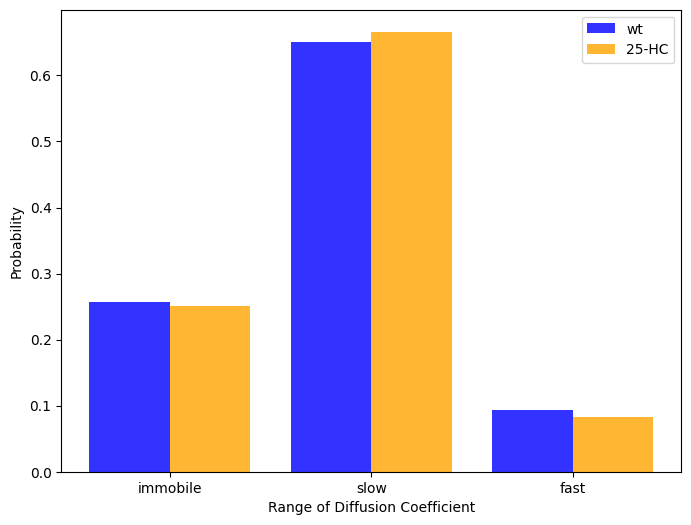

In [40]:
## Ploting bars
# Interpolation of probability values
points = [-0.8, 0.2]
cdf_values_close = np.interp(points, bin_edges[:-1], cdf1)  # Assuming cdf1 and bin_edges from your 'close' dataset
cdf_values_far = np.interp(points, bin_edges[:-1], cdf2)  # Assuming cdf2 and bin_edges from your 'far' dataset

# Calculate probabilities for each range
prob_ranges_close = [cdf_values_close[0], cdf_values_close[1] - cdf_values_close[0], 1 - cdf_values_close[1]]
prob_ranges_far = [cdf_values_far[0], cdf_values_far[1] - cdf_values_far[0], 1 - cdf_values_far[1]]
labels = ['immobile', 'slow', 'fast']
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, prob_ranges_close, width, alpha=0.8, label='wt', color='blue')
rects2 = ax.bar(x + width/2, prob_ranges_far, width, alpha=0.8, label='25-HC', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Range of Diffusion Coefficient')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [102]:
## Heat map STEP vs. TAMSD
# Process data
data1 = seg_ds
data2 = seg_ds_tamsd

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(-1.5,0.5,2), np.linspace(-1.5,0.5,2), color='blue')

ValueError: x and y must have the same length.

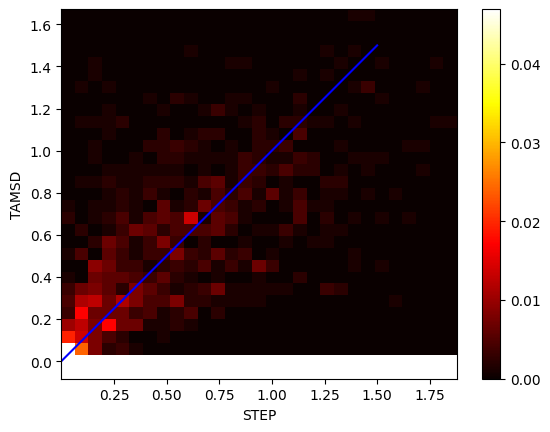

In [37]:
## Heat map STEP vs. TAMSD for alpha
# Process data
data1 = seg_alphas
data2 = seg_alphas_tamsd

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data2, data1, bins=[chosen_bin_size, chosen_bin_size])

# Normalize 
total_data_points = np.sum(hist_2d)
hist_2d_normalized = hist_2d / total_data_points

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(0,1.5,2), np.linspace(0,1.5,2), color='blue')

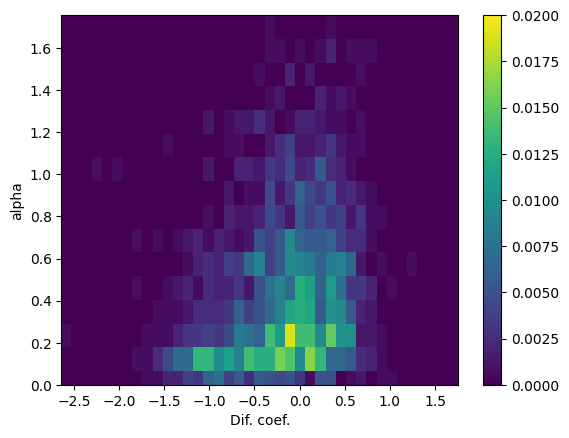

In [103]:
# Relationship diff. coef. and alpha
# Process data
data1 = seg_ds
data2 = seg_alphas

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(data1)))
bin_size2 = int(np.sqrt(len(data2)))
chosen_bin_size = min(bin_size1, bin_size2)
data_range = [min(data1.min(), data2.min()), max(data1.max(), data2.max())]
bins = np.linspace(data_range[0], data_range[1], chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=bins)


# Normalization
total_data_points = np.sum(hist_2d_1)
hist_2d_normalized1 = hist_2d_1 / total_data_points

#Plot
plt.imshow(hist_2d_normalized1, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.02)
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

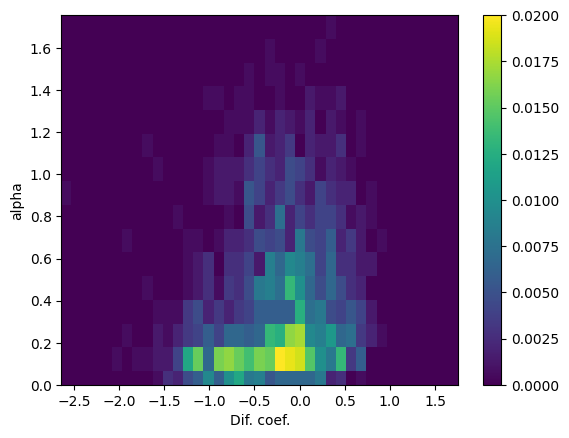

In [104]:
# Relationship diff. coef. and alpha
# Process data
data3 = seg_ds2
data4 = seg_alphas2

# Compute the 2D histogram
hist_2d_2, xedges, yedges = np.histogram2d(data4, data3, bins=bins)


# Normalization
total_data_points = np.sum(hist_2d_2)
hist_2d_normalized2 = hist_2d_2 / total_data_points

#Plot
plt.imshow(hist_2d_normalized2, cmap='viridis', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.02)
plt.gca().set_aspect('auto')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.ylim(0, data_range[1])
plt.colorbar()

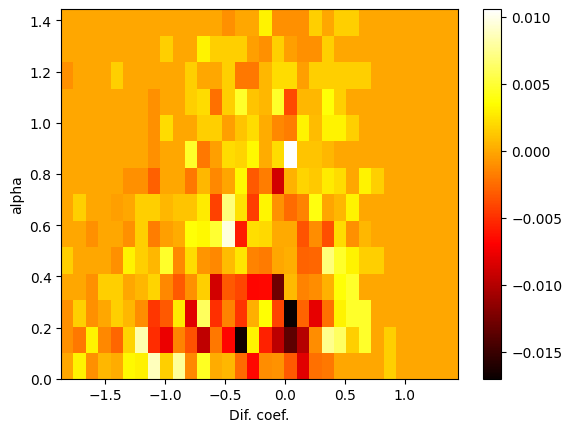

In [38]:
#Subtraction of the histograms
hist_2d_diff = hist_2d_normalized2 - hist_2d_normalized1

#Plot
plt.imshow(hist_2d_diff, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('Dif. coef.')
plt.ylabel('alpha')
plt.gca().set_aspect('auto')
plt.ylim(0, data_range[1])
plt.colorbar()

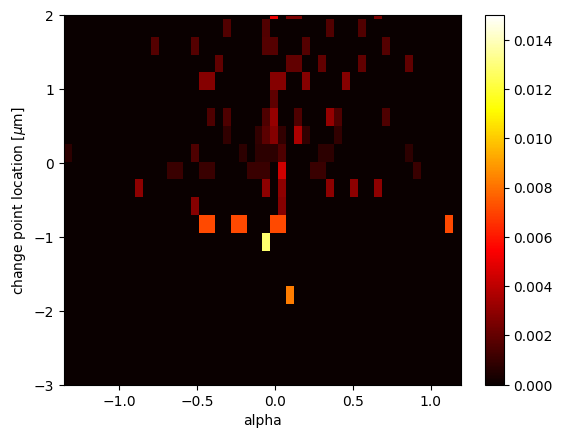

In [92]:
# Relationship diff. coef. change point and distance to MCS
# Process data
data1 = cps_location * 0.1567
data2 = jumps_alpha

# Define the number of bins for each variable
bin_size1 = int(np.sqrt(len(~np.isnan(data1))))
bin_size2 = int(np.sqrt(len(~np.isnan(data2))))
#chosen_bin_size = min(bin_size1, bin_size2)
chosen_bin_size = 50
bin_edges_x = np.linspace(np.nanmin(data2), np.nanmax(data2), chosen_bin_size + 1)
bin_edges_y = np.linspace(np.nanmin(data1), np.nanmax(data1), chosen_bin_size + 1)

# Compute the 2D histogram
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=[bin_edges_x, bin_edges_y])
hist_2d_1 = hist_2d_1.T

# Normalization by the number of points at each distance (all_close)
# Flatten all tensors in all_close and convert to a single NumPy array
all_close_flat = np.concatenate([c.numpy().flatten() for c in all_close2]) * 0.1567
counts, _ = np.histogram(all_close_flat, bins=bin_edges_y)
hist_2d_normalized1 = np.array([row / count if count > 0 else row for row, count in zip(hist_2d_1, counts)])

#Plot
plt.imshow(hist_2d_normalized1, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], vmin=0, vmax=0.015)
plt.xlabel('alpha')
plt.ylabel('change point location [$\mu$m]')
plt.ylim(-3, 2)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.show()

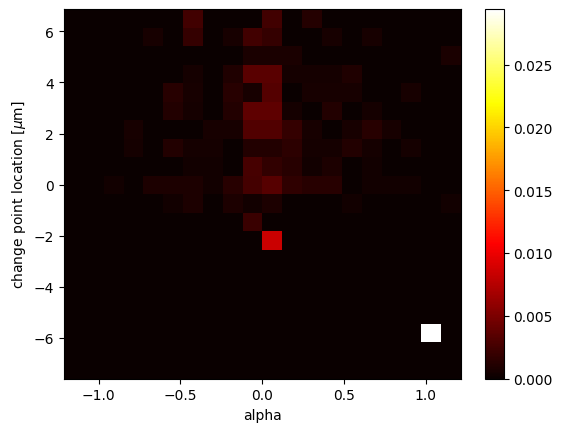

In [111]:
# Relationship diff. coef. change point and distance to MCS
# Process data
data1 = cps_location2 * 0.1567
data2 = jumps_alpha2

# Compute the 2D histogram
#bin_edges_x = np.linspace(np.nanmin(data2), np.nanmax(data2), chosen_bin_size + 1)
#bin_edges_y = np.linspace(np.nanmin(data1), np.nanmax(data1), chosen_bin_size + 1)
hist_2d_1, xedges, yedges = np.histogram2d(data2, data1, bins=[bin_edges_x, bin_edges_y])
hist_2d_1 = hist_2d_1.T

# Normalization by the number of points at each distance (all_close)
# Flatten all tensors in all_close and convert to a single NumPy array
all_close_flat = np.concatenate([c.numpy().flatten() for c in all_close2]) * 0.1567
counts, _ = np.histogram(all_close_flat, bins=bin_edges_y)
hist_2d_normalized2 = np.array([row / count if count > 0 else row for row, count in zip(hist_2d_1, counts)])

#Plot
plt.imshow(hist_2d_normalized2, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('alpha')
plt.ylabel('change point location [$\mu$m]')
#plt.ylim(-10, 40)
plt.colorbar()
plt.gca().set_aspect('auto')
plt.show()

In [93]:
## Ridge plot for alpha vs. changepoint location
# Select data
data1 = location2 * 0.1567
data2 = seg_alphas2

# Classify the predictions into groups
def classify_predictions(predictions):
    bins = [0, 0.2, 0.6, 1.5]  # The edges of the bins for classification
    group_labels = ['confined', 'subdifussive', 'Brownian']
    group_indices = np.digitize(predictions, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(data2)

# Create the DataFrame
df = pd.DataFrame({
    'Value': data1,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['confined', 'subdifussive', 'Brownian'], ordered=True)

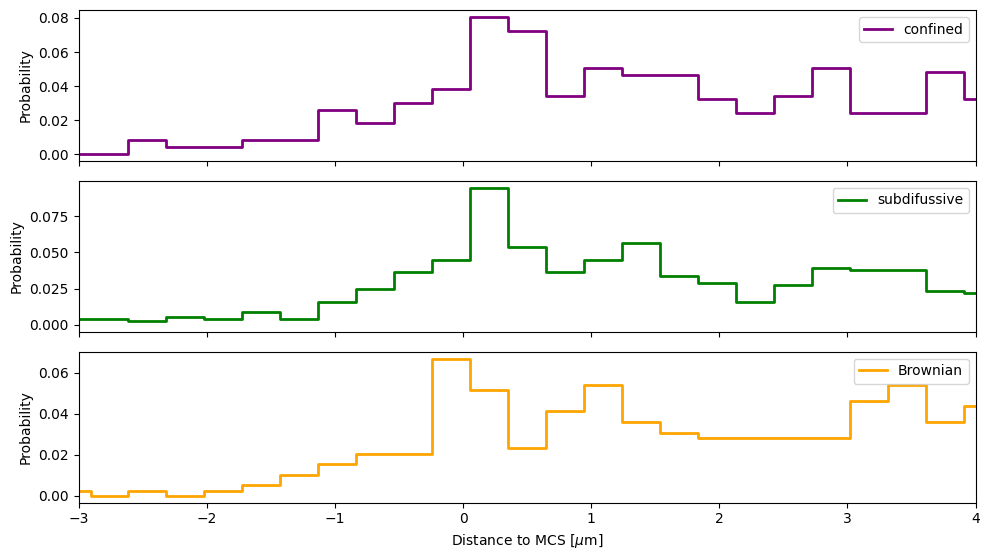

In [94]:
# Define the bin edges for the histogram
bin_edges = np.linspace(df['Value'].min(), df['Value'].max(), 60)

# Colors for each group, make sure the colors correspond to your group labels
colors = {'confined': 'purple', 'subdifussive': 'green', 'Brownian': 'orange'}
# Setup the figure and subplots
fig, axes = plt.subplots(nrows=len(colors), figsize=(10, 6), sharex=True)  # One row for each group

# Ensure axes is an array, even with a single subplot
if len(colors) == 1:
    axes = [axes]

# Plot histogram for each group in its own subplot
for ax, (group, color) in zip(axes, colors.items()):
    # Select the subset of data for the current group
    subset = df[df['Group'] == group]['Value']
    # Compute the histogram values
    counts, bins = np.histogram(subset, bins=bin_edges)
    # Normalize counts so the sum of all bars is 1
    probabilities = counts / counts.sum()
    # Plotting using step for outline
    ax.step(bins[:-1], probabilities, where='post', color=color, label=f"{group}", linewidth=2)
    # Complete the last step to the end of the last bin
    ax.step(bins[-2:], [probabilities[-1], probabilities[-1]], where='post', color=color, linewidth=2)
    
    # Set labels and titles
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')
    ax.set_xlim([-3, 4])  # Ensure all x-axes are the same

# Set common X label
plt.xlabel('Distance to MCS [$\mu$m]')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to fit the suptitle

# Show the plot
plt.show()

In [102]:
## Ridge plot for D vs. changepoint location
# Select data
data1 = location2 * 0.1567
data2 = seg_ds2

# Classify the predictions into groups
def classify_predictions(predictions):
    bins = [-3, -0.5, 0.5, 1.5]  # The edges of the bins for classification
    group_labels = ['immobile', 'slow', 'fast']
    group_indices = np.digitize(predictions, bins) - 1  # Get bin indices
    groups = [group_labels[i] if i < len(group_labels) else 'Unknown' for i in group_indices]
    return groups

# Assign each close1 value to a group based on pred_d
groups = classify_predictions(data2)

# Create the DataFrame
df = pd.DataFrame({
    'Value': data1,
    'Group': groups
})
df['Group'] = pd.Categorical(df['Group'], categories=['immobile', 'slow', 'fast'], ordered=True)

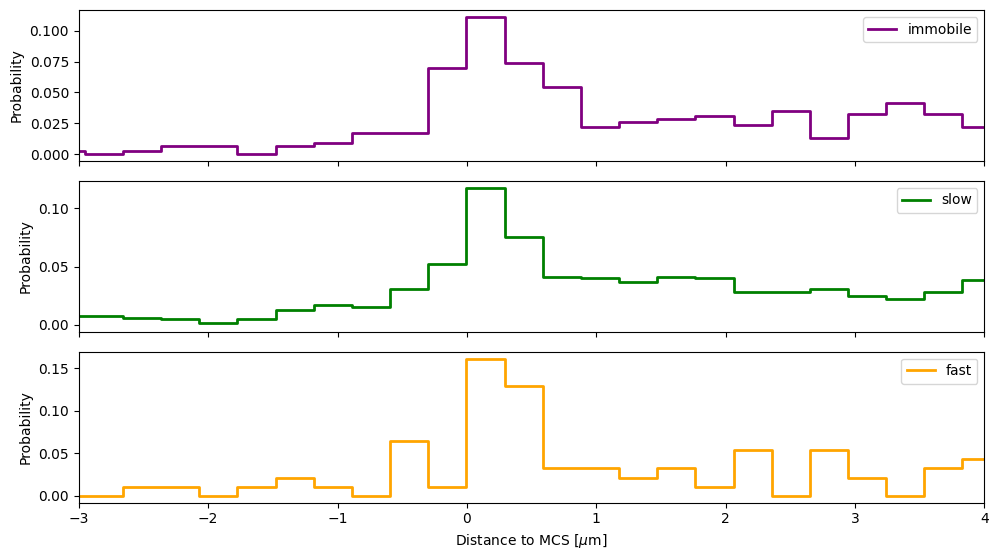

In [103]:
# Define the bin edges for the histogram
bin_edges = np.linspace(df['Value'].min(), df['Value'].max(), 60)

# Colors for each group, make sure the colors correspond to your group labels
colors = {'immobile': 'purple', 'slow': 'green', 'fast': 'orange'}
# Setup the figure and subplots
fig, axes = plt.subplots(nrows=len(colors), figsize=(10, 6), sharex=True)  # One row for each group

# Ensure axes is an array, even with a single subplot
if len(colors) == 1:
    axes = [axes]

# Plot histogram for each group in its own subplot
for ax, (group, color) in zip(axes, colors.items()):
    # Select the subset of data for the current group
    subset = df[df['Group'] == group]['Value']
    # Compute the histogram values
    counts, bins = np.histogram(subset, bins=bin_edges)
    # Normalize counts so the sum of all bars is 1
    probabilities = counts / counts.sum()
    # Plotting using step for outline
    ax.step(bins[:-1], probabilities, where='post', color=color, label=f"{group}", linewidth=2)
    # Complete the last step to the end of the last bin
    ax.step(bins[-2:], [probabilities[-1], probabilities[-1]], where='post', color=color, linewidth=2)
    
    # Set labels and titles
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')
    ax.set_xlim([-3, 4])  # Ensure all x-axes are the same

# Set common X label
plt.xlabel('Distance to MCS [$\mu$m]')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to fit the suptitle

# Show the plot
plt.show()

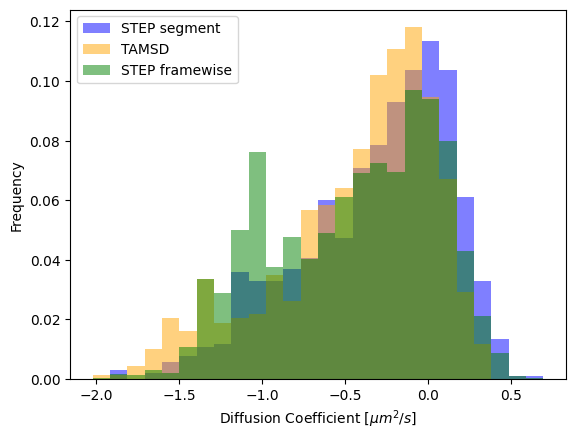

In [114]:
#Representation of Dif Coef of one dataset vs. TAMSD whole traj. 
data1 = np.array(seg_ds)
data2 = np.array(tamsd_dif)
data3 = torch.cat(pred_d).numpy()
#Determine number of bins
num_bins1 = int(np.sqrt(len(data1)))
num_bins2 = int(np.sqrt(len(data2)))
num_bins = min(num_bins1, num_bins2)
#Determine bin edges
min_value = min(data1.min(), data2.min())
max_value = max(data1.max(), data2.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data1, bins=bin_edges)
counts2, _ = np.histogram(data2, bins=bin_edges)
counts3, _ = np.histogram(data3, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
relative_probs3 = counts3 / counts3.sum()
# Plot the histograms
width = np.diff(bin_edges)
plt.bar(bin_edges[:-1], relative_probs1, width=width, alpha=0.5, color='blue', label='STEP segment', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=width, alpha=0.5, color='orange', label='TAMSD', align='edge')
plt.bar(bin_edges[:-1], relative_probs3, width=width, alpha=0.5, color='green', label='STEP framewise', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [415]:
## Classify and calculate the probabilities of the data falling into the combinations of specified ranges for both the diffusion 
#coefficient (Dif. coef) and alpha
#Define bin ranges
dif_coef_bins = [-3, -0.5, 1]  # Ranges for Dif. Coef.
alpha_bins = [0, 0.2, 0.6, 1.5]  # Ranges for alpha

#Data catagorization according to bins
data1 = np.array(seg_ds)
data2 = np.array(seg_alphas)
dif_coef_indices = np.digitize(data1, bins=dif_coef_bins)
alpha_indices = np.digitize(data2, bins=alpha_bins)

# Frequencies for each bin combination
count_matrix = np.zeros((len(dif_coef_bins), len(alpha_bins))) #initialize a 2D array to count frequencies
for i in range(1, len(dif_coef_bins)+1):
    for j in range(1, len(alpha_bins)+1):
        count_matrix[i-1, j-1] = np.sum((dif_coef_indices == i) & (alpha_indices == j))

# Normalize the counts to get probabilities
total_counts = np.sum(count_matrix)
probability_matrix = count_matrix / total_counts
print(len(data1), len(data2))
print(len(pred_d))
print(count_matrix)

226 226
175
[[25.  7. 13.  0.]
 [86. 52. 43.  0.]
 [ 0.  0.  0.  0.]]


In [416]:
# Print probabilities
for i, dif_range in enumerate(zip(dif_coef_bins[:-1], dif_coef_bins[1:])):
    for j, alpha_range in enumerate(zip(alpha_bins[:-1], alpha_bins[1:])):
        print(f"Prob(Dif. Coef. in {dif_range} and alpha in {alpha_range}): {probability_matrix[i, j]:.2f}")

Prob(Dif. Coef. in (-3, -0.5) and alpha in (0, 0.2)): 0.11
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.2, 0.6)): 0.03
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.6, 1.5)): 0.06
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0, 0.2)): 0.38
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.2, 0.6)): 0.23
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.6, 1.5)): 0.19


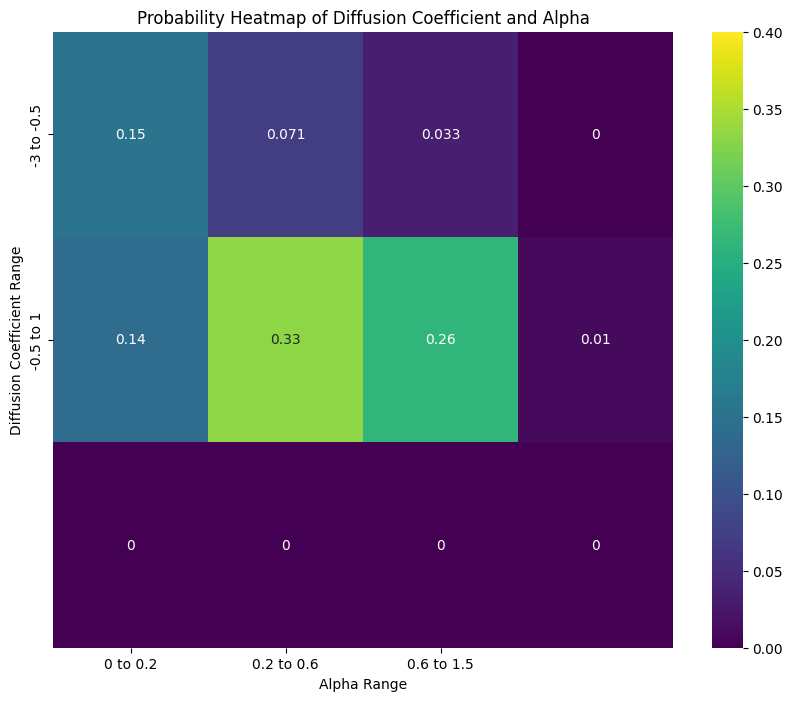

In [330]:
# Visualization
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(probability_matrix, annot=True, cmap="viridis", vmin=0, vmax=0.4, xticklabels=[f"{b[0]} to {b[1]}" for b in zip(alpha_bins[:-1], alpha_bins[1:])],
            yticklabels=[f"{b[0]} to {b[1]}" for b in zip(dif_coef_bins[:-1], dif_coef_bins[1:])])
plt.xlabel("Alpha Range")
plt.ylabel("Diffusion Coefficient Range")
plt.title("Probability Heatmap of Diffusion Coefficient and Alpha")
plt.show()

In [417]:
## Classify and calculate the probabilities of the data falling into the combinations of specified ranges for both the diffusion 
#coefficient (Dif. coef) and alpha
#Define bin ranges
dif_coef_bins = [-3, -0.5, 1]  # Ranges for Dif. Coef.
alpha_bins = [0, 0.2, 0.6, 1.5]  # Ranges for alpha
#Data catagorization according to bins
data1 = np.array(torch.cat(pred_d).numpy())
modified_tensors = [tensor[:-1] for tensor in pred_a] #eliminate the last value
data2 = torch.cat(modified_tensors).numpy()
dif_coef_indices = np.digitize(data1, bins=dif_coef_bins)
alpha_indices = np.digitize(data2, bins=alpha_bins)

# Frequencies for each bin combination
count_matrix = np.zeros((len(dif_coef_bins), len(alpha_bins))) #initialize a 2D array to count frequencies
for i in range(1, len(dif_coef_bins)+1):
    for j in range(1, len(alpha_bins)+1):
        count_matrix[i-1, j-1] = np.sum((dif_coef_indices == i) & (alpha_indices == j))

# Normalize the counts to get probabilities
total_counts = np.sum(count_matrix)
probability_matrix = count_matrix / total_counts
print(len(data1))
print(count_matrix)

3998
[[4.790e+02 1.240e+02 4.020e+02 0.000e+00]
 [1.355e+03 7.800e+02 8.570e+02 0.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00]]


In [418]:
# Print probabilities
for i, dif_range in enumerate(zip(dif_coef_bins[:-1], dif_coef_bins[1:])):
    for j, alpha_range in enumerate(zip(alpha_bins[:-1], alpha_bins[1:])):
        print(f"Prob(Dif. Coef. in {dif_range} and alpha in {alpha_range}): {probability_matrix[i, j]:.2f}")

Prob(Dif. Coef. in (-3, -0.5) and alpha in (0, 0.2)): 0.12
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.2, 0.6)): 0.03
Prob(Dif. Coef. in (-3, -0.5) and alpha in (0.6, 1.5)): 0.10
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0, 0.2)): 0.34
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.2, 0.6)): 0.20
Prob(Dif. Coef. in (-0.5, 1) and alpha in (0.6, 1.5)): 0.21


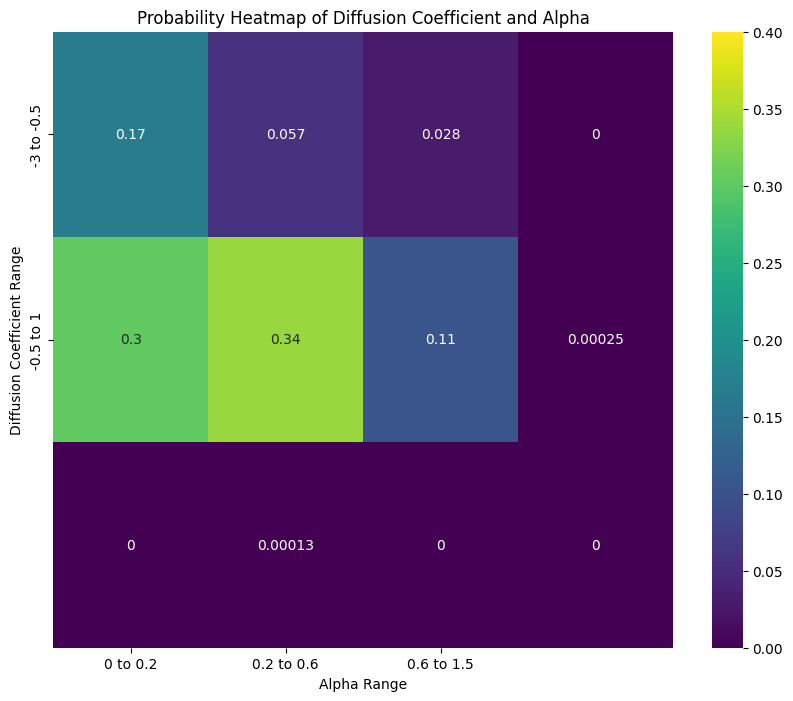

In [196]:
# Visualization
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(probability_matrix, annot=True, cmap="viridis", vmin=0, vmax=0.4, xticklabels=[f"{b[0]} to {b[1]}" for b in zip(alpha_bins[:-1], alpha_bins[1:])],
            yticklabels=[f"{b[0]} to {b[1]}" for b in zip(dif_coef_bins[:-1], dif_coef_bins[1:])])
plt.xlabel("Alpha Range")
plt.ylabel("Diffusion Coefficient Range")
plt.title("Probability Heatmap of Diffusion Coefficient and Alpha")
plt.show()

In [105]:
#Plot by distance to MCS
alpha_bins = [0, 0.2, 0.6, 1.5]
alpha_labels = ['confined', 'subdiffusive', 'Brownian']
dif_coef_bins = [-3, -0.5, 1]
dif_coef_labels = ['slow', 'fast']

def classify_predictions(alphas, ds):
    alpha_indices = np.digitize(alphas, alpha_bins) - 1
    ds_indices = np.digitize(ds, dif_coef_bins) - 1
    groups = []
    for a_idx, d_idx in zip(alpha_indices, ds_indices):
        alpha_part = alpha_labels[a_idx] if 0 <= a_idx < len(alpha_labels) else 'Unknown'
        dif_part = dif_coef_labels[d_idx] if 0 <= d_idx < len(dif_coef_labels) else 'Unknown'
        group = f"{alpha_part}-{dif_part}" if 'Unknown' not in (alpha_part, dif_part) else 'Unknown'
        groups.append(group)
    return groups

In [106]:
# Classify by frames
# Flatten the lists of tensors
all_close_flat = np.concatenate([c[:-1].numpy() for c in all_close]) #we eliminate the last value from each traj
all_close_flat *= 0.1567 #multiply by the pixel size (nm)
pred_d_flat = torch.cat(pred_d).numpy()
pred_a_flat = np.concatenate([p[:-1].numpy() for p in pred_a]) #we eliminate the last value from each traj

# Assign each proximity value to a group based on pred_d and pred_a
groups = classify_predictions(pred_a_flat, pred_d_flat)

# Create the DataFrame
df = pd.DataFrame({
    'Value': all_close_flat,
    'Group': groups
    })

#Remove entries classified as 'Unknown'
df = df[df['Group'] != 'Unknown']

# Optionally, re-establish the categorical type for plotting if needed
unique_groups = sorted(set(df['Group']))  # Update unique groups after filtering
df['Group'] = pd.Categorical(df['Group'], categories=unique_groups, ordered=True)

In [87]:
# Classify by segments
data1 = location2 * 0.1567  # Convert to micrometers
data2 = seg_alphas2  # Alpha values
data3 = seg_ds2      # Diffusion coefficients

groups = classify_predictions(data2, data3)

# Assuming you have already classified your predictions
groups = classify_predictions(data2, data3)

# Create DataFrame
df = pd.DataFrame({
    'Value': data1,
    'Group': groups
    })

# Remove entries classified as 'Unknown'
df = df[df['Group'] != 'Unknown']

# Optionally, re-establish the categorical type for plotting if needed
unique_groups = sorted(set(df['Group']))  # Update unique groups after filtering
df['Group'] = pd.Categorical(df['Group'], categories=unique_groups, ordered=True)

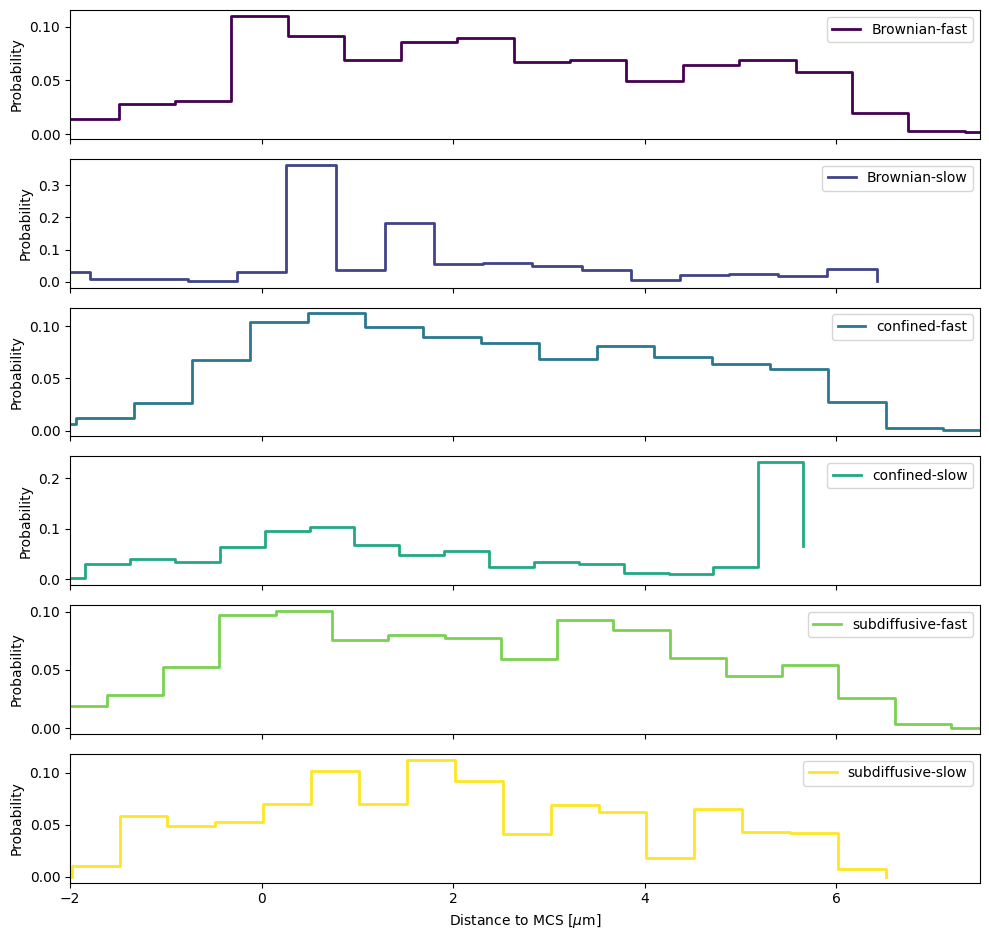

In [107]:
# Setup the colors and plot
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))
fig, axes = plt.subplots(nrows=len(unique_groups), figsize=(10, 10), sharex=True)
if len(unique_groups) == 1:
    axes = [axes]

for ax, (group, color) in zip(axes, zip(unique_groups, colors)):
    subset = df[df['Group'] == group]['Value']
    counts, bins = np.histogram(subset, bins=30)  # Adjust bin count as needed
    probabilities = counts / counts.sum()
    ax.step(bins[:-1], probabilities, where='post', color=color, label=f"{group}", linewidth=2)
    ax.set_ylabel('Probability')
    ax.legend(loc='upper right')

plt.xlabel('Distance to MCS [$\mu$m]')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(-2,7.5)
plt.show()


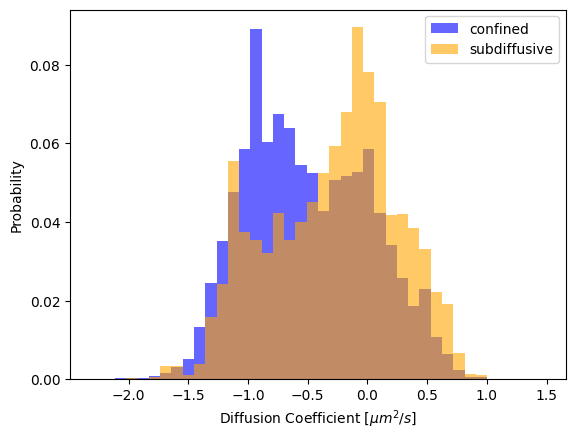

In [59]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd = [], []
for preda, predd in zip(pred_a2, pred_d2):
    preda = preda[:-1]
    # Bolean indexing
    conf = predd[preda < 0.2]
    subd = predd[(preda > 0.2) & (preda < 0.6)]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
data_confined = torch.cat(data_confined).numpy()
data_subd = torch.cat( data_subd).numpy()
#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins = min(num_bins1, num_bins2)
num_bins = 40
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min())
max_value = max(data_confined.max(), data_subd.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='subdiffusive', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
#plt.ylim(0, 0.11)
plt.ylabel('Probability')
plt.legend()
plt.show()

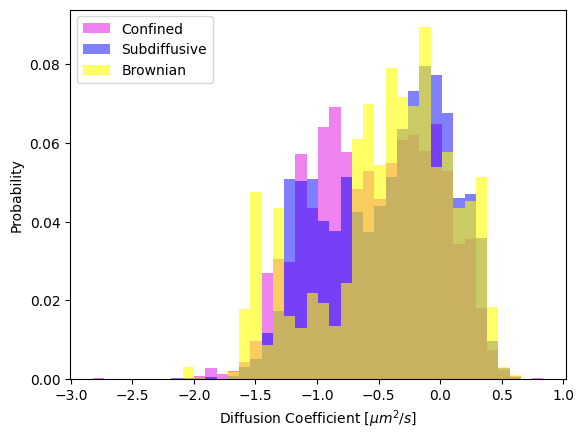

In [48]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd, data_Brow = [], [], []
for preda, predd in zip(pred_a2, pred_d2):
    preda = preda[:-1]
    # Bolean indexing
    conf = predd[preda < 0.2]
    subd = predd[(preda > 0.2) & (preda < 0.6)]
    brow = predd[preda > 0.6]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
    data_Brow.append(brow)
data_confined = torch.cat(data_confined).numpy()
data_subd = torch.cat(data_subd).numpy()
data_Brow = torch.cat(data_Brow).numpy()
#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins3 = int(np.sqrt(len(data_Brow)))
num_bins = min(num_bins1, num_bins2, num_bins3)
num_bins = 40
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min(), data_Brow.min())
max_value = max(data_confined.max(), data_subd.max(), data_Brow.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
counts3, _ = np.histogram(data_Brow, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
relative_probs3 = counts3 / counts3.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=1, color='purple', label='Confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.5, color='blue', label='Subdiffusive', align='edge')
plt.bar(bin_edges[:-1], relative_probs3, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='yellow', label='Brownian', align='edge')
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
#plt.ylim(0, 0.11)
plt.ylabel('Probability')
plt.legend()
plt.show()

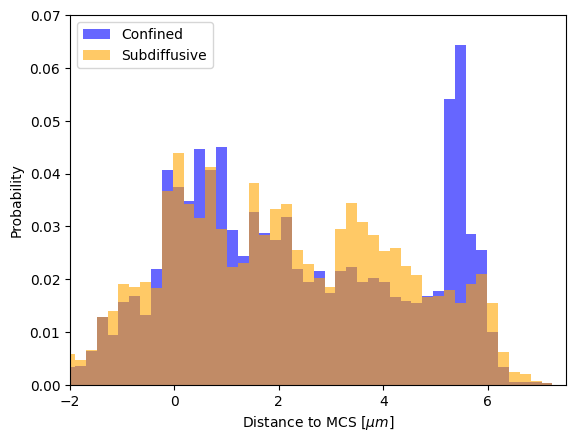

In [117]:
#Dif. coef. of highly confined trajectories (0 to 0.2)
data_confined, data_subd, data_Brow = [], [], []
for preda, c in zip(pred_a, all_close):
    # Bolean indexing
    conf = c[preda < 0.2]
    subd = c[(preda > 0.2) & (preda < 0.6)]
    brow = c[preda > 0.6]
    #Append the data
    data_confined.append(conf)
    data_subd.append(subd)
    data_Brow.append(brow)
data_confined = torch.cat(data_confined).numpy() * 0.1567
data_subd = torch.cat(data_subd).numpy() * 0.1567
data_Brow = torch.cat(data_Brow).numpy() * 0.1567
#Representation close and far 1 dataset
#Determine number of bins
num_bins1 = int(np.sqrt(len(data_confined)))
num_bins2 = int(np.sqrt(len(data_subd)))
num_bins3 = int(np.sqrt(len(data_Brow)))
num_bins = min(num_bins1, num_bins2, num_bins3)
#num_bins = 40
#Determine bin edges
min_value = min(data_confined.min(), data_subd.min(), data_Brow.min())
max_value = max(data_confined.max(), data_subd.max(), data_Brow.max())
bin_edges = np.linspace(min_value, max_value, num_bins + 1)
# Compute histograms without density=True to get the counts
counts1, _ = np.histogram(data_confined, bins=bin_edges)
counts2, _ = np.histogram(data_subd, bins=bin_edges)
counts3, _ = np.histogram(data_Brow, bins=bin_edges)
# Calculate the relative probability for each bin
relative_probs1 = counts1 / counts1.sum()
relative_probs2 = counts2 / counts2.sum()
relative_probs3 = counts3 / counts3.sum()
# Plot the histograms
plt.bar(bin_edges[:-1], relative_probs1, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='blue', label='Confined', align='edge')
plt.bar(bin_edges[:-1], relative_probs2, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='orange', label='Subdiffusive', align='edge')
#plt.bar(bin_edges[:-1], relative_probs3, width=bin_edges[1] - bin_edges[0], alpha=0.6, color='yellow', label='Brownian', align='edge')
plt.xlabel('Distance to MCS [$\mu m$]')
plt.xlim(-2, 7.5)
plt.ylim(0, 0.07)
plt.ylabel('Probability')
plt.legend()
plt.show()